In [1]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
%matplotlib inline

In [2]:
def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values
                    }
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib 
    saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df



In [9]:
# working on angle saccades detection here:
def create_saccade_event_df_using_angles(df, speed_threshold = 2, bokeh_verify_threshold=False,magnitude_calib=1,speed_profile=False):
        
    df['velocity_phi'] = df['phi'].diff()
    df['velocity_theta'] = df['theta'].diff()
    df['velocity_r'] = (df['velocity_theta']**2 + df['velocity_phi']**2)**0.5
    #bokeh_plotter([np.abs(df.velocity_phi.values), np.abs(df.velocity_theta.values)],['phi velocity','theta_velocity'])
    
    # Create a column for saccade detection
    df['is_saccade'] = df['velocity_r'] > speed_threshold
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values
                    }
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    distances_angles = []
    angles = []
    angles_angles = []
    speed_list = []
    
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()): # go over all 
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['velocity_r'].sum()
        distance_traveled_angles = saccade_samples['velocity_r'].sum()
        
        if speed_profile:
            saccade_speed_profile = saccade_samples['velocity_r'].values
            speed_list.append(saccade_speed_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        initial_angle = saccade_samples.iloc[0][['theta','phi']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        endpoint_angle = saccade_samples.iloc[-1][['theta','phi']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        overall_angle_angles = np.arctan2(endpoint_angle['phi'] - initial_angle['phi'],
                                          endpoint_angle['theta'] - initial_angle['theta'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        distances_angles.append(distance_traveled_angles)
        angles_angles.append(overall_angle_angles)
        
    saccade_events_df['magnitude_xy'] = np.array(distances) * magnitude_calib 
    saccade_events_df['angle_xy'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
    saccade_events_df['angle'] = np.rad2deg(angles_angles) % 360 
    saccade_events_df['magnitude'] = np.array(distances)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    #print(len(start_ts))
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    #print(len(end_ts))
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    #print(len(saccade_start_df))
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    start_phi_vals = saccade_start_df['phi']
    start_theta_vals = saccade_start_df['theta']
    
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    end_phi_vals = saccade_end_df['phi']
    end_theta_vals = saccade_end_df['theta']
    
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['initial_phi'] = start_phi_vals.values
    saccade_events_df['initial_theta'] = start_theta_vals.values
    
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['end_phi'] =  end_phi_vals.values
    saccade_events_df['end_theta'] = end_theta_vals.values
    
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    return saccade_events_df



# verification
#xy_r = (np.diff(df.center_x.values)**2 + np.diff(df.center_y.values)**2)**0.5
#bokeh_plotter([, ['x'], peaks=saccade_events_df.saccade_start_ind.values)
#bokeh_plotter([xy_r, df.velocity_r.values],['xy_r','velocity_r'], peaks=saccade_events_df.saccade_start_ind.values)

In [2]:
# This cell will produce a list of blocks that are available for analysis according to the phi/theta transformation model (05/24)

def process_blocks(experiment_path, animal):
    p = pathlib.Path(experiment_path) / animal
    date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
    block_collection = []

    for date_path in date_folder_list:
        date = date_path.name
        blocks_data = []

        # list all the blocks in the folder:
        folder_list = [i for i in date_path.iterdir()]
        for block_p in folder_list:
            if 'block_' in block_p.name: #verify that the block folders only are iterated on
                block_number = block_p.name.split('_')[1]
                analysis_folder = block_p / 'analysis'
                
                left_eye_csv = analysis_folder / 'left_eye_data.csv'
                right_eye_csv = analysis_folder / 'right_eye_data.csv'
                
                does_eye_data_files_exist = left_eye_csv.exists() and right_eye_csv.exists()
                
                columns_list = []
                if does_eye_data_files_exist:
                    # Read both CSV files
                    left_eye_df = pd.read_csv(left_eye_csv)
                    right_eye_df = pd.read_csv(right_eye_csv)

                    # Check if both dataframes have the same structure
                    if left_eye_df.columns.equals(right_eye_df.columns):
                        columns_list = left_eye_df.columns.tolist()
                
                block_data = {
                    'block_number': block_number,
                    'date': date,
                    'does_eye_data_files_exist': does_eye_data_files_exist,
                    'columns_list': columns_list
                }
                blocks_data.append(block_data)

        block_collection.extend(blocks_data)

    return pd.DataFrame(block_collection)

# Example usage:
experiment_path = r"Z:\Nimrod\experiments"
animal = 'PV_62'
result_df = process_blocks(experiment_path, animal)
print(result_df)

NameError: name 'pathlib' is not defined

In [5]:
result_df

block_number        date  does_eye_data_files_exist columns_list
0           005  2023_04_22                      False           []
1           006  2023_04_22                      False           []
2           007  2023_04_22                      False           []
3           008  2023_04_22                      False           []
4           009  2023_04_22                      False           []
..          ...         ...                        ...          ...
66          071  2023_06_19                      False           []
67          072  2023_06_21                      False           []
68          073  2023_06_21                      False           []
69          074  2023_06_21                      False           []
70          075  2023_06_21                      False           []

[71 rows x 4 columns]

# Block collection instantiation

In [3]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
#block_numbers = [23,24,25,26,27,35,38,39,40,41]
block_numbers = [23,24,25,26,27,38,39,40,41,57,70]
bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b


instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

# Load all block data

In [236]:
block = block_collection[0]
def zscore_with_nan(data):
    # Compute mean and standard deviation excluding NaN values
    mean = np.nanmean(data)
    std = np.nanstd(data)

    # Z-score the dataset, replacing NaN values with NaN
    zscored_data = (data - mean) / std

    return zscored_data
bokeh_plotter([zscore_with_nan(block.left_eye_data.center_y)+7,
               zscore_with_nan(block.left_eye_data.center_x),
               zscore_with_nan(block.left_eye_data.phi),
               zscore_with_nan(block.left_eye_data.theta)+7],
              ['center_x','center_y','phi','theta'], plot_name=f'XY_vs_PhiTheta_{block.block_num}',export_path=block.analysis_path)

exporting to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\Nimrod\\experiments\\PV_62\\2023_04_27\\block_023\\analysis\\XY_vs_PhiTheta_023.html'

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 025 has a parsed events file, reading...
getting eye brigtness values for block 025...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_eve

# Saccade detection and analysis

In [0]:
for block in block_collection:
    print(block)
    block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=2,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=2,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)

In [7]:
# detection (old version):
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data, 
                                                                       speed_threshold=2, 
                                                                       bokeh_verify_threshold=False, 
                                                                       magnitude_calib=block.L_pix_size,
                                                                       speed_profile=True)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data, 
                                                                        speed_threshold=2, 
                                                                        bokeh_verify_threshold=False, 
                                                                        magnitude_calib=block.R_pix_size,
                                                                        speed_profile=True)

72it [00:00, 712.70it/s]

PV_62, block 023, on 2023-04-27_10-52-42


915it [00:01, 734.34it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
948it [00:01, 734.90it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
73it [00:00, 722.58it/s]

PV_62, block 024, on 2023-04-27_11-22-56


915it [00:01, 739.68it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
948it [00:01, 747.63it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
73it [00:00, 715.68it/s]

PV_62, block 025, on 2023-04-27_11-52-05


963it [00:01, 739.05it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
998it [00:01, 715.26it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
71it [00:00, 706.63it/s]

PV_62, block 026, on 2023-04-27_12-21-41


949it [00:01, 700.76it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
992it [00:01, 725.67it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
74it [00:00, 738.39it/s]

PV_62, block 027, on 2023-04-27_12-53-31


1111it [00:01, 728.72it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
1110it [00:01, 729.81it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
64it [00:00, 633.71it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1942it [00:02, 683.32it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
1940it [00:02, 686.49it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
67it [00:00, 669.84it/s]

PV_62, block 039, on 2023-05-01_14-44-23


1763it [00:02, 653.69it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
1735it [00:02, 639.05it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
64it [00:00, 633.51it/s]

PV_62, block 040, on 2023-05-01_15-49-30


2019it [00:03, 663.70it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
2113it [00:03, 665.09it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
74it [00:00, 732.68it/s]

PV_62, block 041, on 2023-05-01_16-58-39


750it [00:01, 719.08it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
832it [00:01, 724.11it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
67it [00:00, 663.54it/s]

PV_62, block 057, on 2023-05-08_12-17-49


3996it [00:06, 659.95it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)
3207it [00:04, 656.06it/s]
<ipython-input-2-eb8414a52bf1>:149: RuntimeWarning: invalid value encountered in remainder
  saccade_events_df['angle'] = np.rad2deg(angles) % 360 # Convert radians to degrees and ensure result is in [0, 360)


In [8]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])


In [9]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [15]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df) + len(synced_df) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


887it [00:00, 6967.63it/s]
887it [00:00, 7157.64it/s]


342 914


930it [00:00, 7036.56it/s]

342 914



922it [00:00, 5422.52it/s]

421 964



1066it [00:00, 7268.27it/s]

366 954



740it [00:00, 7378.76it/s]

383 1077


1825it [00:00, 7781.18it/s]
733it [00:00, 7273.75it/s]

970 1857


1715it [00:00, 6918.74it/s]
444it [00:00, 4435.71it/s]

602 1684


1950it [00:00, 5893.82it/s]
728it [00:00, 7510.87it/s]

879 2059
353 796



3902it [00:00, 7406.78it/s]


1399 3011


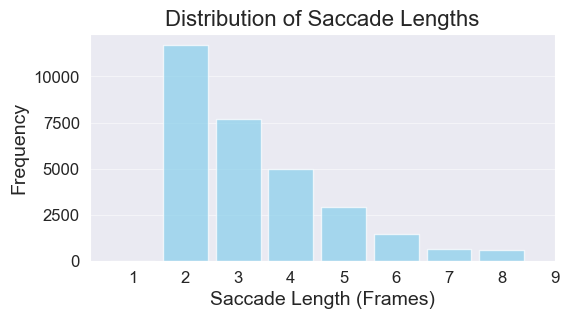

In [35]:
# describe saccade length via histogram:

# Extract 'length' values
saccade_lengths = saccade_collection['length']

# Create histogram with whole number bins
plt.figure(figsize=(6, 3), dpi=100)
plt.hist(saccade_lengths, bins=range(1, 10), color='skyblue', alpha=0.7, rwidth=0.85, align='left')  # align='left' to start bars at integer values

# Add labels and title
plt.xlabel('Saccade Length (Frames)', fontsize=14)  # Updated x-label
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Saccade Lengths', fontsize=16)
plt.xticks(range(1, 10))  # Set x-ticks to be the integer bin edges
plt.grid(axis='y', alpha=0.5)

# Show the plot
plt.show()


In [50]:
block_num = saccade_collection.iloc[0].block
eye = saccade_collection.iloc[0].eye
start_ind = saccade_collection.iloc[0].saccade_start_ind
end_ind = saccade_collection.iloc[0].saccade_end_ind
before_after_frames = 3
if eye == 'L':
    diameter_before = block_dict[block_num].left_eye_data.iloc[start_ind-before_after_frames:start_ind].pupil_diameter.values
    diameter_after = block_dict[block_num].left_eye_data.iloc[end_ind:end_ind+before_after_frames].pupil_diameter.values
elif eye == 'R':
    diameter_before = block_dict[block_num].right_eye_data.iloc[start_ind-before_after_frames:start_ind].pupil_diameter.values
    diameter_after = block_dict[block_num].right_eye_data.iloc[end_ind:end_ind+before_after_frames].pupil_diameter.values


[16.04095936 16.0309137  16.07659711] [15.92819859 15.71961302 15.74171969]


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pupil_diameter_by_saccade_length(saccade_collection, block_dict, length, before_after_frames=3):
    """
    Plots z-scored pupil diameter profiles for saccades of a given length, 
    with before/after data, using specified colors and plot size.

    Args:
        saccade_collection (pd.DataFrame): DataFrame with saccade information.
        block_dict (dict): Dictionary containing BlockSync objects.
        length (int): Saccade length to filter by.
        before_after_frames (int): Number of frames to include before and after the saccade.
    """
    filtered_saccades = saccade_collection[saccade_collection['length'] == length]

    # Separate saccades based on diameter change (positive or negative)
    positive_saccades = filtered_saccades[np.array([profile[-1] - profile[0] > 0 for profile in filtered_saccades['diameter_profile']])]
    negative_saccades = filtered_saccades[np.array([profile[-1] - profile[0] < 0 for profile in filtered_saccades['diameter_profile']])]

    def get_pupil_data(saccades, block_dict, before_after_frames):
        all_pupil_traces = []
        for _, saccade in saccades.iterrows():
            block_num = saccade['block']
            eye = saccade['eye']
            start_ind = saccade['saccade_start_ind']
            end_ind = saccade['saccade_end_ind']

            if eye == 'L':
                eye_data = block_dict[block_num].left_eye_data
            else:
                eye_data = block_dict[block_num].right_eye_data

            pupil_trace = np.concatenate([
                eye_data.iloc[start_ind - before_after_frames:start_ind]['pupil_diameter'].values,
                saccade['diameter_profile'],
                eye_data.iloc[end_ind:end_ind + before_after_frames]['pupil_diameter'].values
            ])
            # Z-score the pupil trace
            pupil_trace = (pupil_trace - np.nanmean(pupil_trace)) / np.nanstd(pupil_trace)
            all_pupil_traces.append(pupil_trace)
        return all_pupil_traces

    # Get pupil data for positive and negative saccades
    positive_traces = get_pupil_data(positive_saccades, block_dict, before_after_frames)
    negative_traces = get_pupil_data(negative_saccades, block_dict, before_after_frames)

    # Calculate and plot average traces (with length correction and Z-scoring)
    max_length = max(len(trace) for trace in positive_traces + negative_traces)
    x = np.arange(-before_after_frames, max_length - before_after_frames)
    avg_positive = np.nanmean(np.array([np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan) for trace in positive_traces]), axis=0)
    avg_negative = np.nanmean(np.array([np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan) for trace in negative_traces]), axis=0)

    # Adjust figure size
    plt.figure(figsize=(12, 8))  

    plt.plot(x, avg_positive, color='hotpink', label=f'Avg. Increasing (N={len(positive_traces)})', linewidth=2)
    plt.plot(x, avg_negative, color='cyan', label=f'Avg. Decreasing (N={len(negative_traces)})', linewidth=2)

    # Plot individual traces (with length correction and Z-scoring)
    for trace in positive_traces:
        padded_trace = np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan)
        plt.plot(x, padded_trace, color='lightpink', alpha=0.2)
    for trace in negative_traces:
        padded_trace = np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan)
        plt.plot(x, padded_trace, color='lightblue', alpha=0.2)

    # Add vertical lines and labels
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x=length, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel('Frames Relative to Saccade Onset', fontsize=14)
    plt.ylabel('Z-Scored Pupil Diameter', fontsize=14)  # Updated y-label
    plt.title(f'Z-Scored Pupil Diameter for Saccades of Length {length}', fontsize=16)  # Updated title
    plt.legend()
    plt.show()
 
# Example usage
for length in range(2, 6):
    plot_pupil_diameter_by_saccade_length(saccade_collection, block_dict, length)


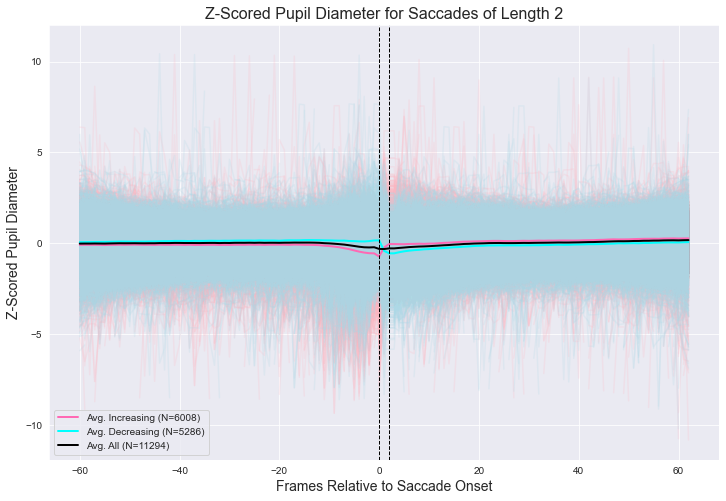

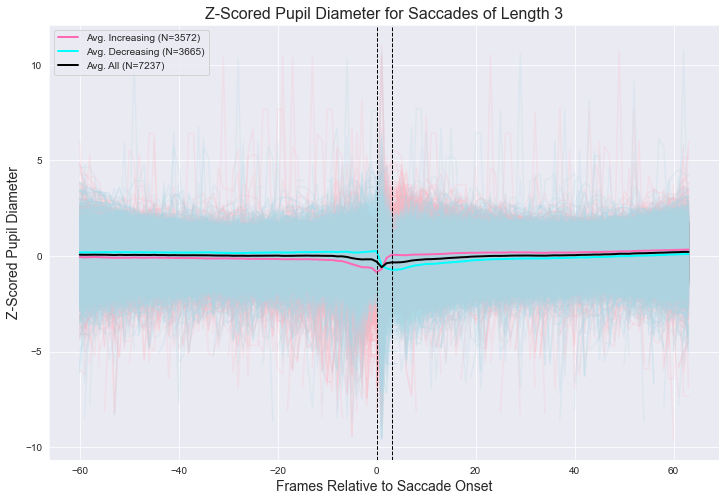

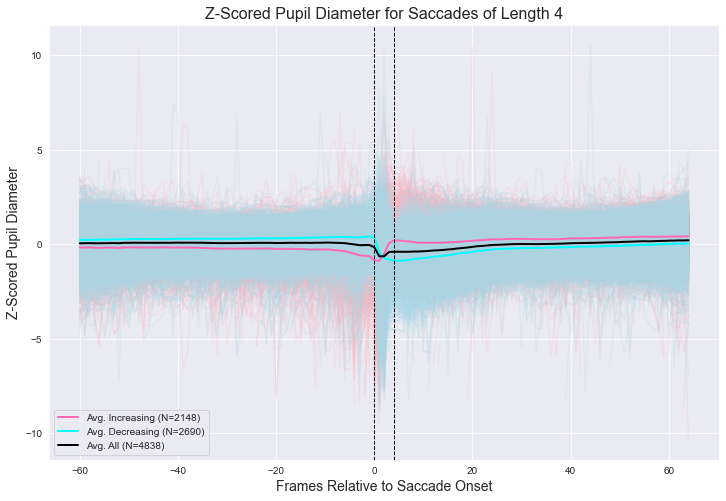

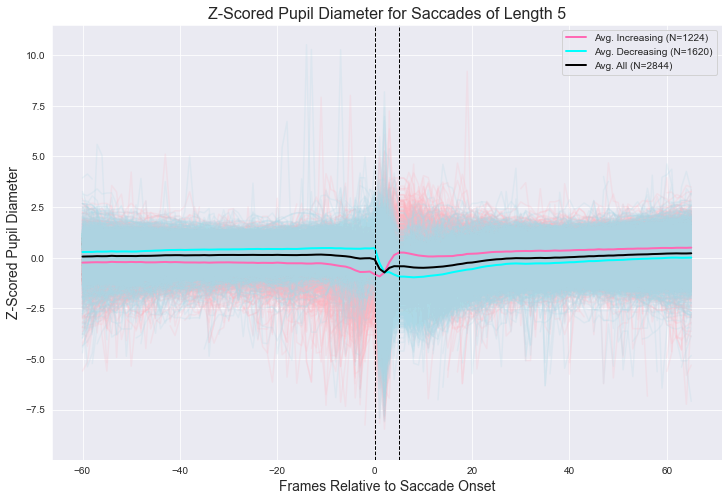

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pupil_diameter_by_saccade_length(saccade_collection, block_dict, length, before_after_frames=3):
    """
    Plots z-scored pupil diameter profiles for saccades of a given length, 
    with before/after data, using specified colors and plot size. Includes
    average traces for increasing, decreasing, and all saccades.

    Args:
        saccade_collection (pd.DataFrame): DataFrame with saccade information.
        block_dict (dict): Dictionary containing BlockSync objects.
        length (int): Saccade length to filter by.
        before_after_frames (int): Number of frames to include before and after the saccade.
    """
    filtered_saccades = saccade_collection[saccade_collection['length'] == length]

    # Separate saccades based on diameter change (positive or negative)
    positive_saccades = filtered_saccades[np.array([profile[-1] - profile[0] > 0 for profile in filtered_saccades['diameter_profile']])]
    negative_saccades = filtered_saccades[np.array([profile[-1] - profile[0] < 0 for profile in filtered_saccades['diameter_profile']])]

    def get_pupil_data(saccades, block_dict, before_after_frames):
        all_pupil_traces = []
        for _, saccade in saccades.iterrows():
            block_num = saccade['block']
            eye = saccade['eye']
            start_ind = saccade['saccade_start_ind']
            end_ind = saccade['saccade_end_ind']

            if eye == 'L':
                eye_data = block_dict[block_num].left_eye_data
            else:
                eye_data = block_dict[block_num].right_eye_data

            pupil_trace = np.concatenate([
                eye_data.iloc[start_ind - before_after_frames:start_ind]['pupil_diameter'].values,
                saccade['diameter_profile'],
                eye_data.iloc[end_ind:end_ind + before_after_frames]['pupil_diameter'].values
            ])
            # Z-score the pupil trace
            pupil_trace = (pupil_trace - np.nanmean(pupil_trace)) / np.nanstd(pupil_trace)
            all_pupil_traces.append(pupil_trace)
        return all_pupil_traces

    # Get pupil data for positive and negative saccades
    positive_traces = get_pupil_data(positive_saccades, block_dict, before_after_frames)
    negative_traces = get_pupil_data(negative_saccades, block_dict, before_after_frames)

    # Calculate and plot individual traces (with length correction and Z-scoring)
    max_length = max(len(trace) for trace in positive_traces + negative_traces)
    x = np.arange(-before_after_frames, max_length - before_after_frames)
    
    plt.figure(figsize=(12, 8))
    
    for trace in positive_traces:
        padded_trace = np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan)
        plt.plot(x, padded_trace, color='lightpink', alpha=0.2)
    for trace in negative_traces:
        padded_trace = np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan)
        plt.plot(x, padded_trace, color='lightblue', alpha=0.2)
          
    
    # Calculate and plot average traces (with length correction and Z-scoring)
    avg_positive = np.nanmean(np.array([np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), 
                                               mode='constant', constant_values=np.nan) for trace in positive_traces]), axis=0)
    avg_negative = np.nanmean(np.array([np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), 
                                               mode='constant', constant_values=np.nan) for trace in negative_traces]), axis=0)
    avg_all = np.nanmean(np.array([np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), 
                                          mode='constant', constant_values=np.nan) for trace in positive_traces + negative_traces]), axis=0)

    # Plot average traces on top
    plt.plot(x, avg_positive, color='hotpink', label=f'Avg. Increasing (N={len(positive_traces)})', linewidth=2)
    plt.plot(x, avg_negative, color='cyan', label=f'Avg. Decreasing (N={len(negative_traces)})', linewidth=2)
    plt.plot(x, avg_all, color='black', label=f'Avg. All (N={len(positive_traces) + len(negative_traces)})', linewidth=2)


    # Add vertical lines and labels
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x=length, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel('Frames Relative to Saccade Onset', fontsize=14)
    plt.ylabel('Z-Scored Pupil Diameter', fontsize=14)  # Updated y-label
    plt.title(f'Z-Scored Pupil Diameter for Saccades of Length {length}', fontsize=16)  # Updated title
    plt.legend()
    plt.show()

# Example usage
for length in range(2, 6):
    plot_pupil_diameter_by_saccade_length(saccade_collection, block_dict, length, before_after_frames=60)


 --- Analysis for L Eye ---


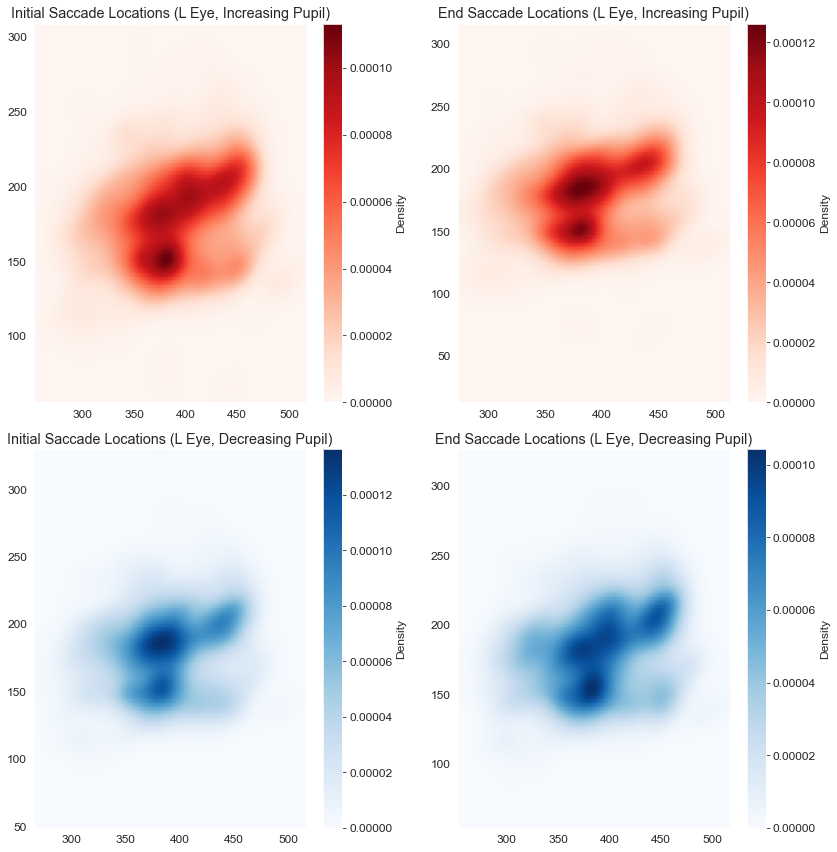

Independent t-test for initial_x (L Eye): t = 1.955, p = 0.051
Independent t-test for initial_y (L Eye): t = -2.714, p = 0.007
Independent t-test for end_x (L Eye): t = -0.203, p = 0.839
Independent t-test for end_y (L Eye): t = -2.632, p = 0.008

Increasing Pupil Saccades (L Eye):
  Mean Angle: 331.06 degrees
  Circular Variance: 6.705

Decreasing Pupil Saccades (L Eye):
  Mean Angle: 337.89 degrees
  Circular Variance: 4.040


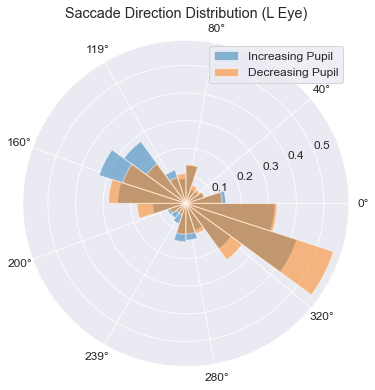


 --- Analysis for R Eye ---


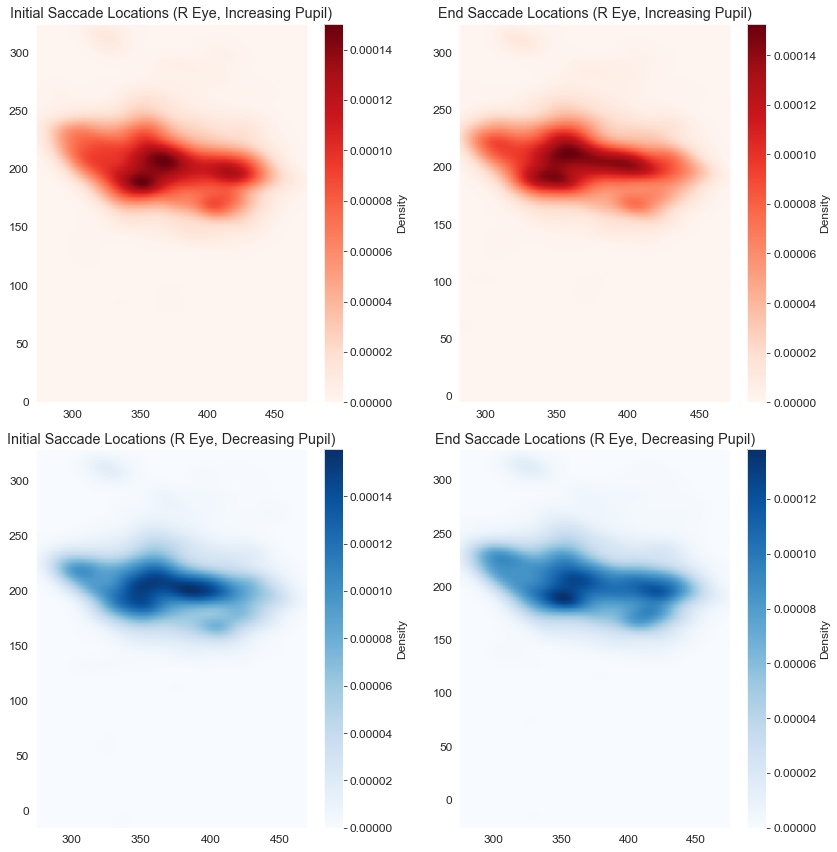

Independent t-test for initial_x (R Eye): t = -0.508, p = 0.612
Independent t-test for initial_y (R Eye): t = -2.687, p = 0.007
Independent t-test for end_x (R Eye): t = -2.713, p = 0.007
Independent t-test for end_y (R Eye): t = 1.354, p = 0.176

Increasing Pupil Saccades (R Eye):
  Mean Angle: 117.39 degrees
  Circular Variance: 4.563

Decreasing Pupil Saccades (R Eye):
  Mean Angle: 312.39 degrees
  Circular Variance: 6.723


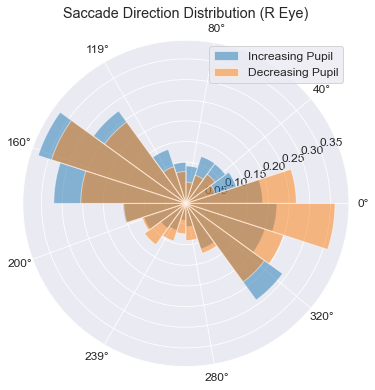

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, circmean, circvar, gaussian_kde

def analyze_saccade_locations(saccade_collection):
    """
    Analyzes location and directional statistics for saccades, separating analysis by eye
    and pupil diameter change. Uses 2D KDE plots for locations and a polar plot for directions.

    Args:
        saccade_collection (pd.DataFrame): DataFrame with saccade information.
    """
    for eye in ['L', 'R']:
        eye_saccades = saccade_collection[saccade_collection['eye'] == eye]

        # Separate saccades based on diameter change
        positive_saccades = eye_saccades[np.array([profile[-1] - profile[0] > 0 for profile in eye_saccades['diameter_profile']])]
        negative_saccades = eye_saccades[np.array([profile[-1] - profile[0] < 0 for profile in eye_saccades['diameter_profile']])]

        print(f"\n --- Analysis for {eye} Eye ---\n")

        # Location Analysis (2D KDE Plots - Separate for Each Condition)
        fig, axes = plt.subplots(2, 2, figsize=(12, 12)) # 2 rows x 2 columns of subplots

        for i, (saccade_group, label, cmap) in enumerate(zip(
            [positive_saccades, negative_saccades],
            ['Increasing Pupil', 'Decreasing Pupil'],
            ['Reds', 'Blues']  # Using standard colormaps
        )):
            for j, (coord_x, coord_y, title) in enumerate(zip(
                ['initial_x', 'end_x'], ['initial_y', 'end_y'], ['Initial', 'End']
            )):
                x = saccade_group[coord_x]
                y = saccade_group[coord_y]

                # Calculate 2D KDE
                xy = np.vstack([x, y])
                kde = gaussian_kde(xy, bw_method='scott')
                
                # Evaluate KDE on a grid
                x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
                positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
                z = np.reshape(kde(positions).T, x_grid.shape)

                # Plot KDE on the correct subplot
                ax = axes[i, j]  # Select the subplot based on row (i) and column (j)
                im = ax.imshow(np.rot90(z), cmap=cmap, extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
                ax.set_title(f'{title} Saccade Locations ({eye} Eye, {label})')
                fig.colorbar(im, ax=ax, label='Density')

        plt.tight_layout()
        plt.show()
        
        # Perform independent t-tests for initial/end x and y positions
        for coord in ['initial_x', 'initial_y', 'end_x', 'end_y']:
            t_stat, p_value = ttest_ind(positive_saccades[coord], negative_saccades[coord], nan_policy='omit')
            print(f"Independent t-test for {coord} ({eye} Eye): t = {t_stat:.3f}, p = {p_value:.3f}")

        # Directional Analysis (Polar Plot)
        plt.figure(figsize=(6, 6))

        # Convert angles to radians for circular statistics
        positive_angles_rad = np.radians(positive_saccades['angle'])
        negative_angles_rad = np.radians(negative_saccades['angle'])

        # Correct angles for left eye (mirror image)
        if eye == 'L':
            positive_angles_rad = -positive_angles_rad + 2 * np.pi
            negative_angles_rad = -negative_angles_rad + 2 * np.pi

        # Plot polar histograms of saccade angles
        plt.subplot(111, projection='polar')
        plt.hist(positive_angles_rad, bins=20, density=True, alpha=0.5, label='Increasing Pupil')
        plt.hist(negative_angles_rad, bins=20, density=True, alpha=0.5, label='Decreasing Pupil')
        plt.title(f'Saccade Direction Distribution ({eye} Eye)')
        plt.legend()

        # Add angle labels
        angles = np.linspace(0, 2 * np.pi, 9, endpoint=False)
        plt.xticks(angles, [f"{int(np.degrees(angle))}\u00b0" for angle in angles])  # Unicode degree symbol
        
        # Calculate and print circular statistics
        positive_mean_angle = circmean(positive_angles_rad, high=2*np.pi, low=0)
        positive_var_angle = circvar(positive_angles_rad, high=2*np.pi, low=0)
        negative_mean_angle = circmean(negative_angles_rad, high=2*np.pi, low=0)
        negative_var_angle = circvar(negative_angles_rad, high=2*np.pi, low=0)

        print(f"\nIncreasing Pupil Saccades ({eye} Eye):")
        print(f"  Mean Angle: {np.degrees(positive_mean_angle):.2f} degrees")
        print(f"  Circular Variance: {positive_var_angle:.3f}")

        print(f"\nDecreasing Pupil Saccades ({eye} Eye):")
        print(f"  Mean Angle: {np.degrees(negative_mean_angle):.2f} degrees")
        print(f"  Circular Variance: {negative_var_angle:.3f}")

        plt.show()

# Example usage
analyze_saccade_locations(saccade_collection)


<ipython-input-74-a060dead6e5a>:37: RuntimeWarning: invalid value encountered in true_divide
  speed_trace = (speed_trace - np.nanmean(speed_trace)) / np.nanstd(speed_trace)


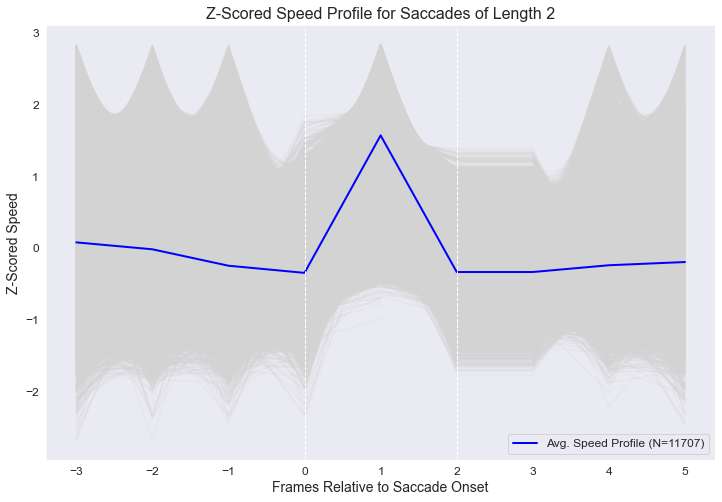

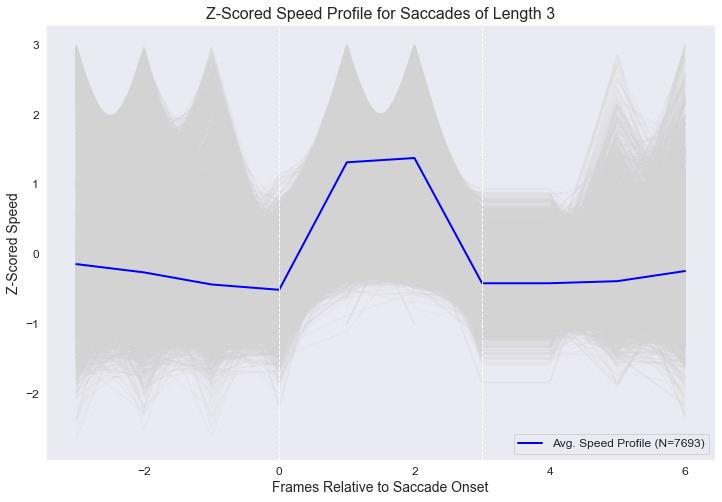

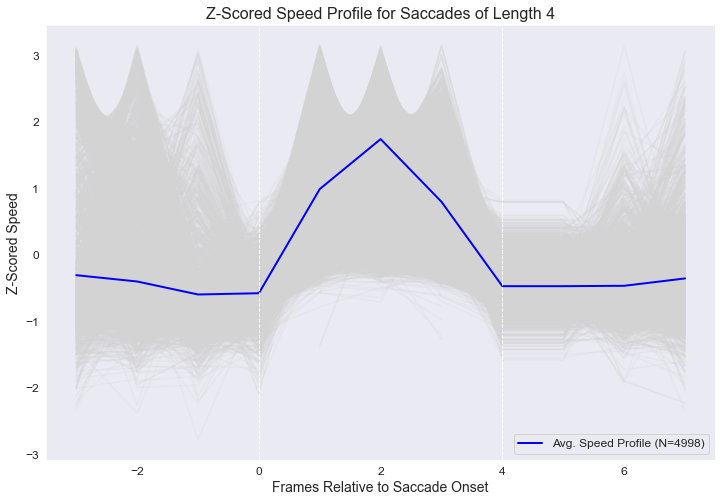

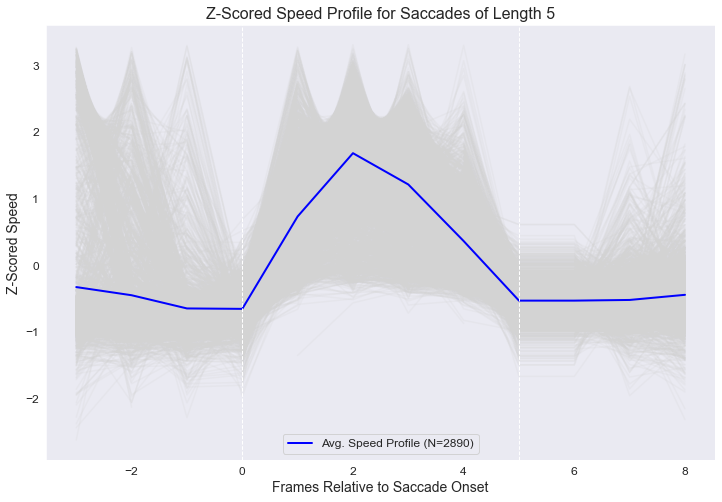

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, circmean, circvar, gaussian_kde

def plot_speed_profile_by_saccade_length(saccade_collection, block_dict, length, before_after_frames=3):
    """
    Plots z-scored speed profiles for saccades of a given length, with before/after data.

    Args:
        saccade_collection (pd.DataFrame): DataFrame with saccade information.
        block_dict (dict): Dictionary containing BlockSync objects.
        length (int): Saccade length to filter by.
        before_after_frames (int): Number of frames to include before and after the saccade.
    """
    filtered_saccades = saccade_collection[saccade_collection['length'] == length]

    def get_speed_data(saccades, block_dict, before_after_frames):
        all_speed_traces = []
        for _, saccade in saccades.iterrows():
            block_num = saccade['block']
            eye = saccade['eye']
            start_ind = saccade['saccade_start_ind']
            end_ind = saccade['saccade_end_ind']

            if eye == 'L':
                eye_data = block_dict[block_num].left_eye_data
            else:
                eye_data = block_dict[block_num].right_eye_data

            speed_trace = np.concatenate([
                eye_data.iloc[start_ind - before_after_frames:start_ind]['speed_r'].values,
                saccade['speed_profile'],
                eye_data.iloc[end_ind:end_ind + before_after_frames]['speed_r'].values
            ])
            # Z-score the speed trace only if it has valid data
            if not np.all(np.isnan(speed_trace)):
                speed_trace = (speed_trace - np.nanmean(speed_trace)) / np.nanstd(speed_trace)
            all_speed_traces.append(speed_trace)
        return all_speed_traces

    # Get speed data for the filtered saccades
    speed_traces = get_speed_data(filtered_saccades, block_dict, before_after_frames)

    # Calculate maximum length
    max_length = max(len(trace) for trace in speed_traces)
    x = np.arange(-before_after_frames, max_length - before_after_frames)
    
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot individual traces (with length correction and Z-scoring)
    for trace in speed_traces:
        # z-score only if there's valid data
        if not np.all(np.isnan(trace)):
            padded_trace = np.pad((trace - np.nanmean(trace)) / np.nanstd(trace), (0, max_length - len(trace)), mode='constant', constant_values=np.nan)
            plt.plot(x, padded_trace, color='lightgrey', alpha=0.2)

    # Calculate and plot average speed trace
    avg_speed = np.nanmean(np.array([np.pad(trace, (0, max_length - len(trace)), mode='constant', constant_values=np.nan) for trace in speed_traces]), axis=0)
    plt.plot(x, avg_speed, color='blue', label=f'Avg. Speed Profile (N={len(speed_traces)})', linewidth=2)

    # Add vertical lines for saccade start/end
    plt.axvline(x=0, color='white', linestyle='dashed', linewidth=1)
    plt.axvline(x=length, color='white', linestyle='dashed', linewidth=1)

    plt.xlabel('Frames Relative to Saccade Onset', fontsize=14)
    plt.ylabel('Z-Scored Speed', fontsize=14)
    plt.title(f'Z-Scored Speed Profile for Saccades of Length {length}', fontsize=16)
    plt.legend()
    plt.show()


# Example usage (assuming you have saccade_collection and block_dict):
for length in range(2, 6):  # Plot for saccade lengths 2, 3, 4, and 5
    plot_speed_profile_by_saccade_length(saccade_collection, block_dict, length)


In [67]:
# pupil psd graphs
block_num = '040'
block = block_dict[block_num]
df = block.left_eye_data



df = get_zscored_column(df,'pupil_diameter')
large_timestamps = df.query('pupil_diameter_zscore > 1.5').ms_axis
small_timestamps = df.query('pupil_diameter_zscore < -1.5').ms_axis





In [92]:
# construction, chunk_times
#initialize
thresholds = [(1.0, 2)]  # Example list of thresholds
blocks = [block_dict['039']]
eye = 'left'

all_psds = []
all_large_pupil_psds = []
all_small_pupil_psds = []
all_large_pupil_durations = []
all_small_pupil_durations = []

for threshold in thresholds:
    for block in blocks:
        if eye == 'left':
            eye_df = block.left_eye_data
        elif eye == 'right':
            eye_df = block.right_eye_data
        else:
            raise NameError('The eye can only be set to "left" or "right"')
        
        df = get_zscored_column(eye_df.copy(), 'pupil_diameter')
    
        large_timestamps = df.query(f'pupil_diameter_zscore > {threshold[0]} and pupil_diameter_zscore < {threshold[1]}').ms_axis
        small_timestamps = df.query(f'pupil_diameter_zscore < -{threshold[0]} and pupil_diameter_zscore > -{threshold[1]} ').ms_axis
        

times = large_timestamps.values
#times = np.array([0,1,2,16,18,19,20,21,28,29])
chunk_threshold = 1000 # Milliseconds
min_chunk_length = 3000 # Milliseconds
diff_arr = np.diff(times)
gaps = diff_arr > chunk_threshold
chunks_end_inds = np.where(gaps == True)[0]
chunks_start_inds = chunks_end_inds + 1
chunks_start_inds = np.insert(chunks_start_inds,0,0)
chunks_start = times[chunks_start_inds]
chunks_end_inds = np.insert(chunks_end_inds,len(chunks_end_inds),len(times)-1)
chunks_end = times[chunks_end_inds]

chunks_length = chunks_end - chunks_start
length_filter = chunks_length > min_chunk_length
chunks_length = chunks_length[length_filter]
chunks_start = chunks_start[length_filter]


neuro_data, neuro_timestamps = block.oe_rec.get_data(channels= [15],
                                                     start_time_ms=chunks_start,
                                                     window_ms = np.min(chunks_length),
                                                     convert_to_mv=True,
                                                     return_timestamps=True, repress_output=False)


sample removed for window #0
sample removed for window #28
sample removed for window #29
The requested data segment between 69600 ms and [[72639.85]] ms exceeds the recording length, and will be 0-padded to fit the other windows


In [98]:
#neuro_data[0][0][]
np.min(chunks_length)

3039.850000000006

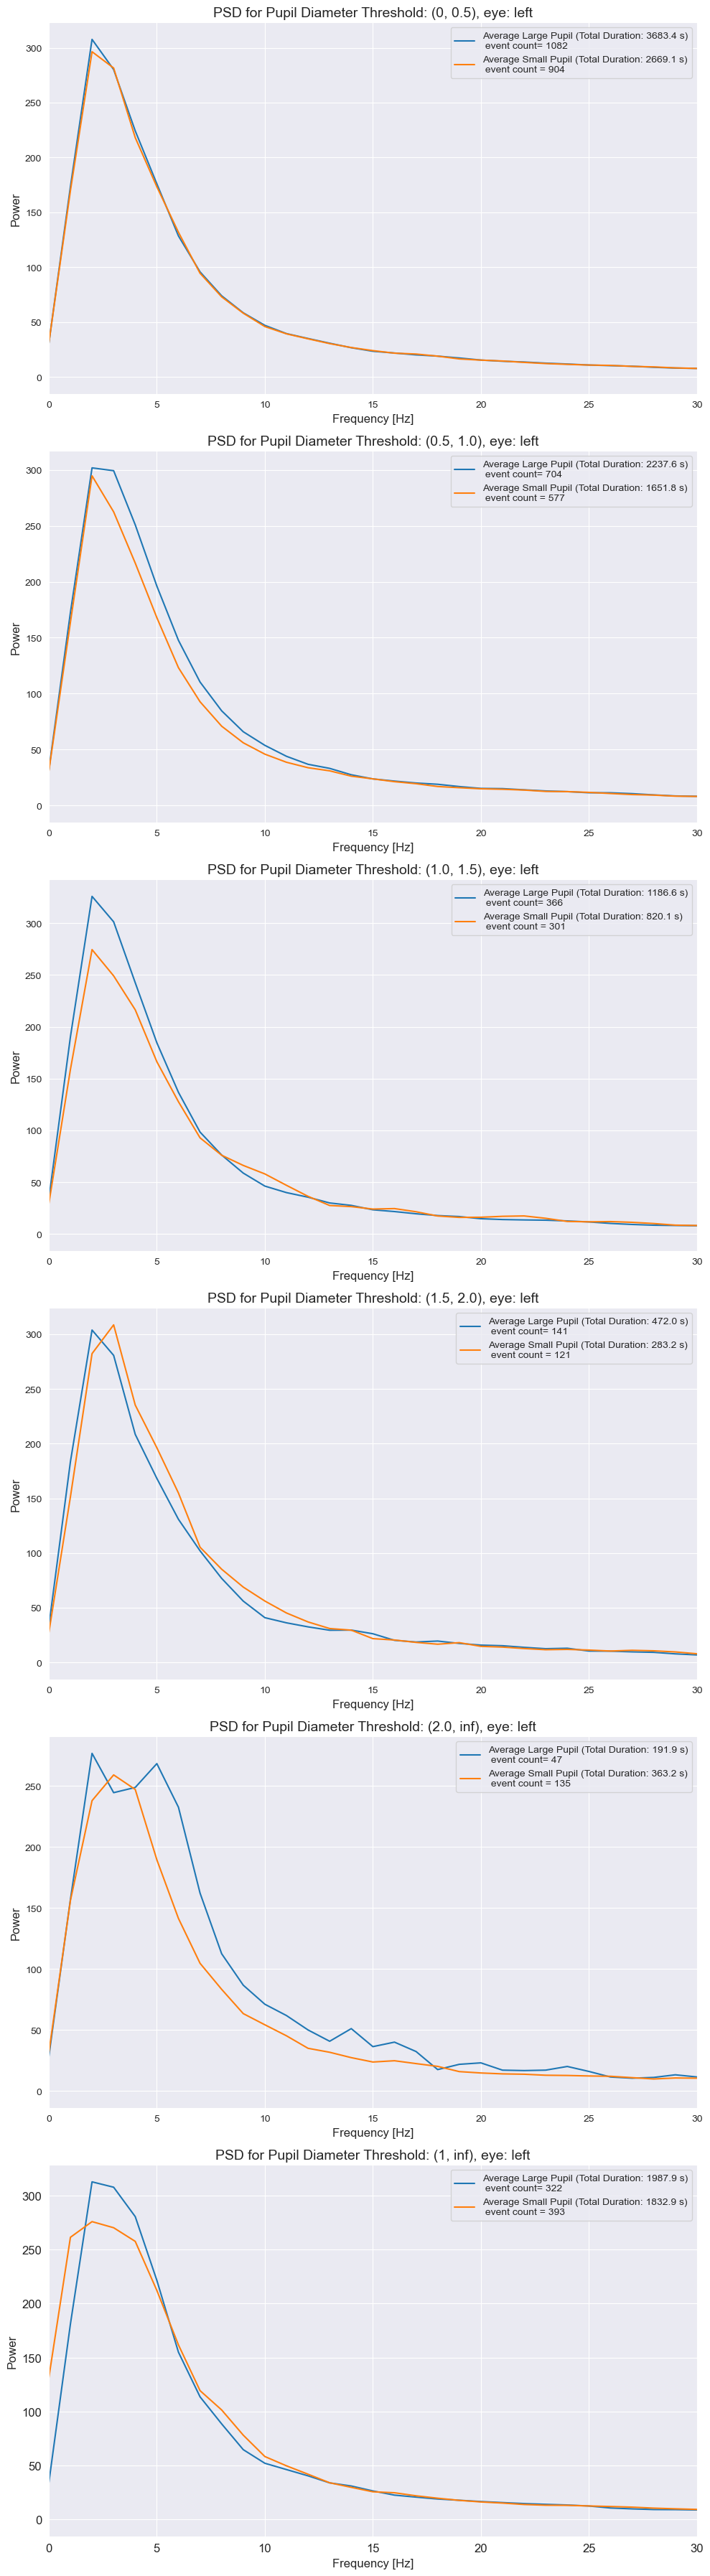

In [110]:
def get_zscored_column(df,column_to_zscore):
    mean = df[column_to_zscore].mean(skipna=True)
    std = df[column_to_zscore].std(skipna=True)
    zscore_column = (df[column_to_zscore] - mean) / std
    df[column_to_zscore + '_zscore'] = zscore_column
    return df

def calculate_average_psd(block, windows_start_ms, windows_length_ms, nperseg=20000, noverlap=10000, electrode_to_use=[15]):
    """
    This function expects a segments variable that looks like this:
    [(segment1_start_ms,segment1_length_ms), (segment2_start_ms,segment2_length_ms), ... ect.]
    and will return the average PSD for the time segments in question
    :param segments: 
    :return: 
    """
    neuro_data_list = []
    neuro_timestamp_list = []
    overall_length = 0
    overall_used = 0
    for i, (window_start, window_length) in enumerate(zip(windows_start_ms,windows_length_ms)):
                
        try:
            neuro_data, neuro_timestamps = block.oe_rec.get_data(channels= electrode_to_use,
                                                                 start_time_ms=[window_start],
                                                                 window_ms = [window_length],
                                                                 convert_to_mv=True,
                                                                 return_timestamps=True, repress_output=True)
        except TypeError:
            neuro_data = None
            neuro_timestamps = None
        
        if neuro_data is not None:
            neuro_data_list.append(neuro_data)
            neuro_timestamp_list.append(neuro_timestamps)
            overall_length += window_length
            overall_used += 1
        else: 
            print(f'had problem with block {block.block_num} segment {i} of length = {window_length}')
    all_psds = []
    
    for array in neuro_data_list:
        a = np.squeeze(array)
        f, pxx = signal.welch(a, fs=block.sample_rate, nperseg=nperseg, noverlap=noverlap)
        all_psds.append(pxx)
    average_psd = np.mean(all_psds, axis=0)
    
    return f, average_psd, overall_length, overall_used

def chunk_times_old(times, min_gap=17.5, min_length=1000):
    """Chunks a list of times into consecutive and non-consecutive samples.

    Args:
        times: A list of time values (in milliseconds).
        min_gap: The minimum time gap in milliseconds to consider samples non-consecutive.
        min_length: The minimum chunk length in milliseconds to keep (default: 1000).

    Returns:
        list: A list of tuples (start_time, length) for each chunk meeting the criteria.
    """
    chunks = []
    current_chunk_start = times[0]

    for i in range(1, len(times)):
        time_diff = times[i] - times[i - 1]

        if time_diff > min_gap:
            # End the current chunk and start a new one
            chunk_length = times[i - 1] - current_chunk_start
            if chunk_length >= min_length:  # Filter by minimum length
                chunks.append((current_chunk_start, chunk_length))
            current_chunk_start = times[i]

    # Handle the last chunk
    chunk_length = times[-1] - current_chunk_start
    if chunk_length >= min_length:
        chunks.append((current_chunk_start, chunk_length))

    return chunks

def chunk_times(times, chunk_threshold=170, min_chunk_length=1000):
    
    diff_arr = np.diff(times)
    gaps = diff_arr > chunk_threshold
    chunks_end_inds = np.where(gaps == True)[0]
    chunks_start_inds = chunks_end_inds + 1
    chunks_start_inds = np.insert(chunks_start_inds,0,0)
    chunks_start = times[chunks_start_inds]
    chunks_end_inds = np.insert(chunks_end_inds,len(chunks_end_inds),len(times)-1)
    chunks_end = times[chunks_end_inds]
    
    chunks_length = chunks_end - chunks_start
    length_filter = chunks_length > min_chunk_length
    chunks_length = chunks_length[length_filter]
    chunks_start = chunks_start[length_filter]

    
    return chunks_start, chunks_length

def analyze_pupil_psds(blocks, thresholds, nperseg=20000, noverlap=10000, eye='Left', plot_normalized=True, export_path=False, log_scale=False):
    """Analyzes and plots PSDs for different pupil diameter thresholds across multiple blocks.

    Args:
        blocks: A list of block objects.
        thresholds: A list of z-score thresholds for pupil diameter.
        nperseg: Length of each segment for Welch's method (default: 20000).
        noverlap: Number of points to overlap between segments (default: 10000).
    """
    fig, axs = plt.subplots(len(thresholds), figsize=(10, 6 * len(thresholds)), dpi=100)

    for i, threshold in enumerate(thresholds):
        ax = axs[i] if len(thresholds) > 1 else axs  # Handle single subplot case
        all_psds = []
        all_large_pupil_psds = []
        all_small_pupil_psds = []
        all_large_pupil_durations = []
        all_small_pupil_durations = []

        for block in blocks:
            if eye == 'left':
                eye_df = block.left_eye_data
            elif eye == 'right':
                eye_df = block.right_eye_data
            
            df = get_zscored_column(eye_df.copy(), 'pupil_diameter')

            large_timestamps = df.query(f'pupil_diameter_zscore > {threshold}').ms_axis
            small_timestamps = df.query(f'pupil_diameter_zscore < -{threshold}').ms_axis

            large_chunks = chunk_times(large_timestamps.values, chunk_threshold=1000, min_chunk_length=2000)
            small_chunks = chunk_times(small_timestamps.values, chunk_threshold=1000, min_chunk_length=2000)
            
            try:
                _, large_pupil_psd = calculate_average_psd(block, large_chunks, nperseg, noverlap)
                _, small_pupil_psd = calculate_average_psd(block, small_chunks, nperseg, noverlap)
                
                all_psds.append(large_pupil_psd)
                all_psds.append(small_pupil_psd)
                all_large_pupil_psds.append(large_pupil_psd)
                all_small_pupil_psds.append(small_pupil_psd)
            
                
                # Calculate and store durations in seconds
                large_pupil_duration = sum(chunk[1] for chunk in large_chunks) / 1000
                small_pupil_duration = sum(chunk[1] for chunk in small_chunks) / 1000
                
                all_large_pupil_durations.append(large_pupil_duration)
                all_small_pupil_durations.append(small_pupil_duration)
            except TypeError:
                print(f'block {block} has a  problem at this threshold')
        # Calculate averages
        avg_large_pupil_psd = np.mean(all_large_pupil_psds, axis=0)
        avg_small_pupil_psd = np.mean(all_small_pupil_psds, axis=0)
        avg_psd = np.mean(all_psds, axis=0) 
        normalized_large_pupil_psd = avg_large_pupil_psd / avg_psd
        normalized_small_pupil_psd = avg_small_pupil_psd / avg_psd
        
        total_large_pupil_duration = np.sum(all_large_pupil_durations)
        total_small_pupil_duration = np.sum(all_small_pupil_durations)

        # Plot
        f = calculate_average_psd(block, large_chunks, nperseg, noverlap)[0]  # Get frequency values
        if plot_normalized:
            ax.plot(f, normalized_large_pupil_psd, label=f'Normalized Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)')
            ax.plot(f, normalized_small_pupil_psd, label=f'Nomrlaized Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)')
        else:
            ax.plot(f, avg_large_pupil_psd, label=f'Average Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)')
            ax.plot(f, avg_small_pupil_psd, label=f'Average Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)')
        ax.set_xlim(0, 30)
        #ax.set_ylim(0, 400)
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
        ax.set_ylabel('Power', fontsize=12)
        ax.set_title(f'PSD for Pupil Diameter Threshold: {threshold}, eye: {eye}', fontsize=14)
        ax.legend(fontsize=10)
        if log_scale:
            ax.set_yscale('log')
        
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=8)

    plt.tight_layout()
    if export_path:
        if not isinstance(export_path, pathlib.Path):
            raise TypeError("export_path must be a pathlib.Path object or False.")
        plt.savefig(export_path, format='pdf')
        print(f"Figure saved to {export_path}")

    plt.show()
    
    return large_chunks, small_chunks

def analyze_pupil_psds_bands(blocks, 
                             thresholds, 
                             nperseg=20000, 
                             noverlap=10000, 
                             eye='Left', 
                             plot_normalized=True, 
                             export_path=False, 
                             log_scale=False,
                             electrode_to_use=[15]):
    """Analyzes and plots PSDs for different pupil diameter thresholds across multiple blocks.

    Args:
        blocks: A list of block objects.
        thresholds: A list of z-score thresholds for pupil diameter.
        nperseg: Length of each segment for Welch's method (default: 20000).
        noverlap: Number of points to overlap between segments (default: 10000).
    """
    fig, axs = plt.subplots(len(thresholds), figsize=(10, 6 * len(thresholds)), dpi=100)

    for i, threshold in enumerate(thresholds):
        ax = axs[i] if len(thresholds) > 1 else axs  # Handle single subplot case
        all_psds = []
        all_large_pupil_psds = []
        all_small_pupil_psds = []
        large_chunks_count = 0
        small_chunks_count = 0
        overall_large_length = 0
        overall_small_length = 0
        
        for block in blocks:
            if eye == 'left':
                eye_df = block.left_eye_data
            elif eye == 'right':
                eye_df = block.right_eye_data
                
            df = get_zscored_column(eye_df.copy(), 'pupil_diameter')

            large_timestamps = df.query(f'pupil_diameter_zscore > {threshold[0]} and pupil_diameter_zscore < {threshold[1]}').ms_axis
            small_timestamps = df.query(f'pupil_diameter_zscore < -{threshold[0]} and pupil_diameter_zscore > -{threshold[1]} ').ms_axis

            large_chunks_start, large_chunks_length = chunk_times(large_timestamps.values)
            small_chunks_start, small_chunks_length = chunk_times(small_timestamps.values)

            f, large_pupil_psd, chunks_length, chunks_used = calculate_average_psd(block,
                                                                                   large_chunks_start,
                                                                                   large_chunks_length,
                                                                                   nperseg,
                                                                                   noverlap)
            large_chunks_count += chunks_used
            overall_large_length += chunks_length
            
            _, small_pupil_psd, chunks_length, chunks_used = calculate_average_psd(block, 
                                                                                   small_chunks_start, 
                                                                                   small_chunks_length, 
                                                                                   nperseg, 
                                                                                   noverlap)
            small_chunks_count += chunks_used
            overall_small_length += chunks_length
            
            all_psds.append(large_pupil_psd)
            all_psds.append(small_pupil_psd)
            all_large_pupil_psds.append(large_pupil_psd)
            all_small_pupil_psds.append(small_pupil_psd)
               

        # Calculate averages
        avg_large_pupil_psd = np.mean(all_large_pupil_psds, axis=0)
        avg_small_pupil_psd = np.mean(all_small_pupil_psds, axis=0)
        avg_psd = np.mean(all_psds, axis=0) 
        normalized_large_pupil_psd = avg_large_pupil_psd / avg_psd
        normalized_small_pupil_psd = avg_small_pupil_psd / avg_psd
        
        total_large_pupil_duration = overall_large_length / 1000
        total_small_pupil_duration = overall_small_length / 1000

        # Plot
        if plot_normalized:
            ax.plot(f, normalized_large_pupil_psd, label=f'Normalized Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s) '
                                                         f'\n event count= {large_chunks_count}')
            ax.plot(f, normalized_small_pupil_psd, label=f'Nomrlaized Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)'
                                                         f'\n event count = {small_chunks_count}')
        else:
            ax.plot(f, avg_large_pupil_psd, label=f'Average Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)'
                                                  f'\n event count= {large_chunks_count}')
            ax.plot(f, avg_small_pupil_psd, label=f'Average Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)'
                                                  f'\n event count = {small_chunks_count}')
        ax.set_xlim(0, 30)
        #ax.set_ylim(0, 400)
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
        ax.set_ylabel('Power', fontsize=12)
        ax.set_title(f'PSD for Pupil Diameter Threshold: {threshold}, eye: {eye}', fontsize=14)
        ax.legend(fontsize=10)
        if log_scale:
            ax.set_yscale('log')
        
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=8)

    plt.tight_layout()
    if export_path:
        if not isinstance(export_path, pathlib.Path):
            raise TypeError("export_path must be a pathlib.Path object or False.")
        plt.savefig(export_path, format='pdf')
        print(f"Figure saved to {export_path}")

    plt.show()
    
    return 
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = pathlib.Path(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_pupil_diameter_psds_left_eye.pdf')
thresholds = [(0,0.5),(0.5,1.0),(1.0,1.5), (1.5,2.0), (2.0, np.inf), (1,np.inf)]  # Example list of thresholds
blocks = [block_dict['039'],block_dict['040'], block_dict['041'], block_dict['057'],block_dict['070']]  # Example list of block objects
# l_large_chunks, l_small_chunks = analyze_pupil_psds(blocks, 
#                                                     thresholds, 
#                                                     eye='left', 
#                                                     plot_normalized=False, 
#                                                     export_path=False,
#                                                     log_scale=False)
analyze_pupil_psds_bands(blocks, thresholds, eye='left', plot_normalized=False, export_path=False, log_scale=False, electrode_to_use=[15])

had problem with block 057 segment 5 of length = 1001.6999999999971


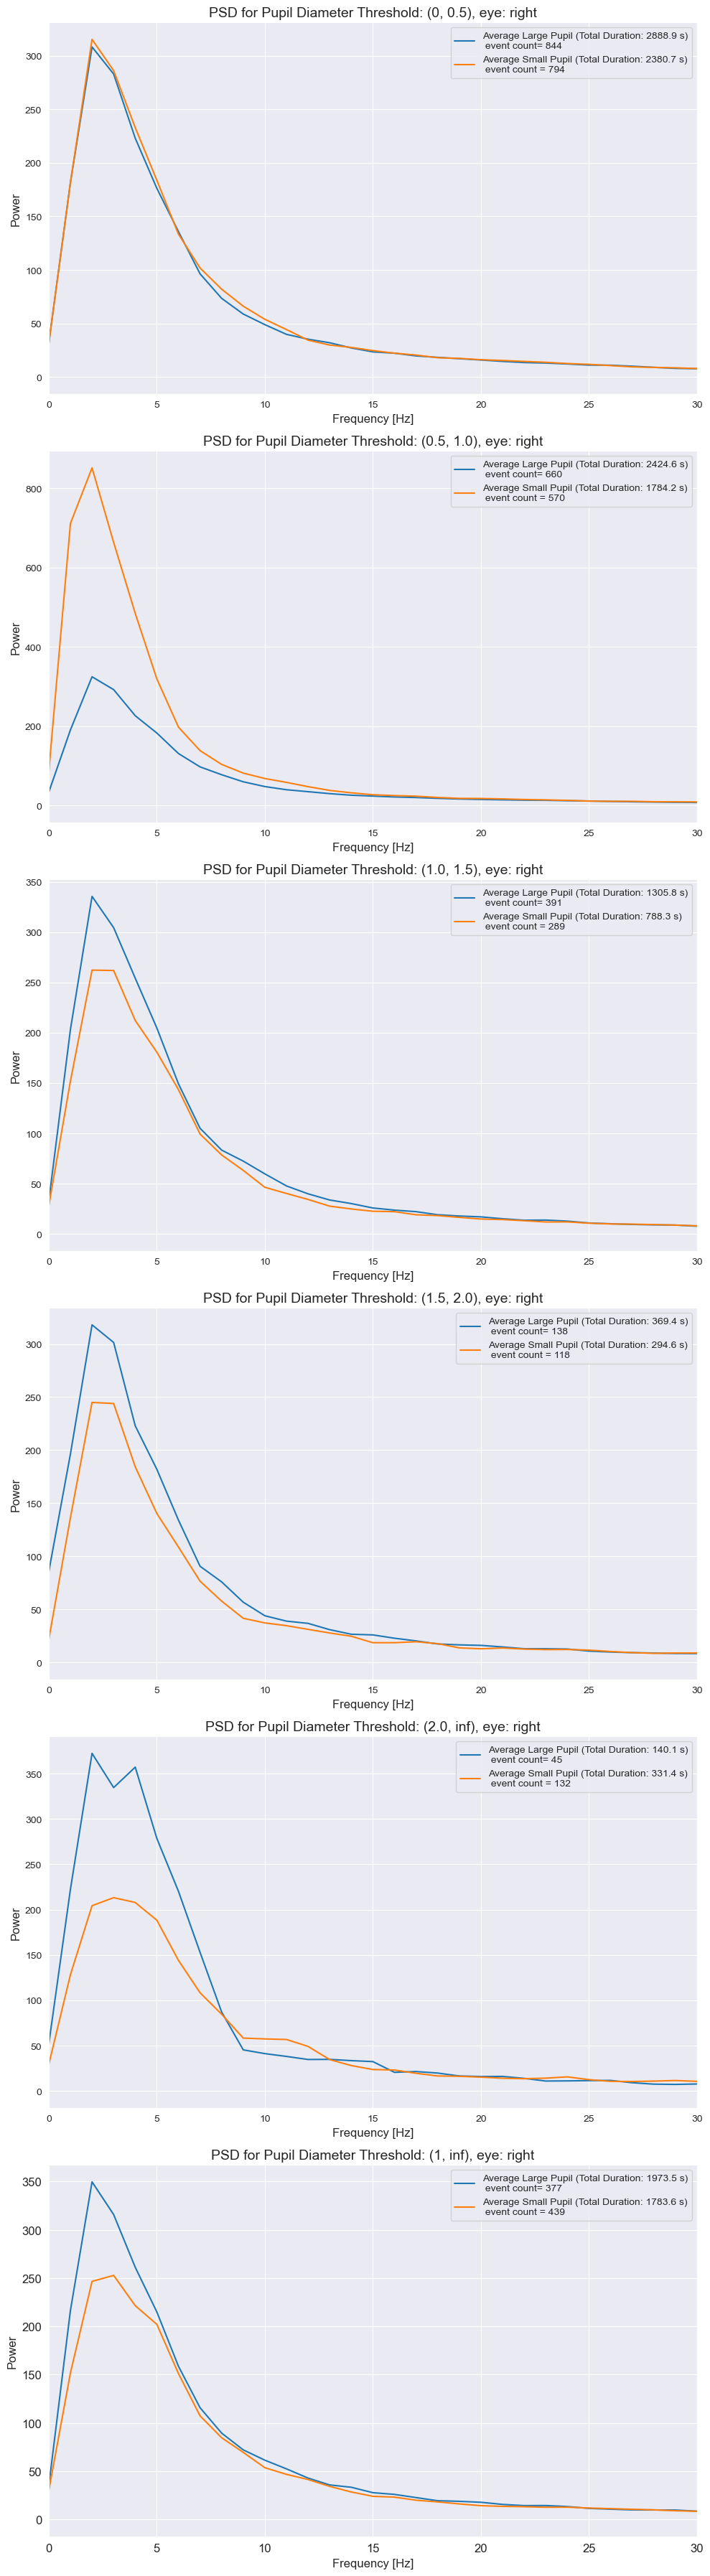

In [111]:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = pathlib.Path(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_pupil_diameter_psds_right_eye.pdf')
# thresholds = [1.0, 1.5, 2.0]  # Example list of thresholds
# blocks = [block_dict['040'], block_dict['038'], block_dict['057']]  # Example list of block objects
# r_large_chunks,r_small_chunks = analyze_pupil_psds(blocks, 
#                                                thresholds, 
#                                                eye='right', 
#                                                export_path=export_path)

analyze_pupil_psds_bands(blocks, thresholds, eye='right', plot_normalized=False, export_path=False, log_scale=False, electrode_to_use=[2])

In [5]:
def get_pupil_diameter_according_to_major_axis(block):
    l_df = block.left_eye_data
    r_df = block.right_eye_data
    l_df['pupil_diameter_pixels'] = l_df.major_ax * 2 * np.pi
    r_df['pupil_diameter_pixels'] = r_df.major_ax * 2 * np.pi
    l_df['pupil_diameter'] = l_df['pupil_diameter_pixels'] * block.L_pix_size
    r_df['pupil_diameter'] = r_df['pupil_diameter_pixels'] * block.R_pix_size
    return r_df, l_df

block.right_eye_data, block.left_eye_data = get_pupil_diameter_according_to_major_axis(block)

PV_62, block 023, on 2023-04-27_10-52-42 16.99501129791347 9.6803731763714
PV_62, block 024, on 2023-04-27_11-22-56 14.884073142007832 9.900075073279249
PV_62, block 025, on 2023-04-27_11-52-05 16.307372451041857 10.011999212976919
PV_62, block 026, on 2023-04-27_12-21-41 17.726565378005517 10.175216609425974
PV_62, block 027, on 2023-04-27_12-53-31 19.043562094626534 9.261666461161324
PV_62, block 038, on 2023-05-01_13-57-45 9.907365190068386 8.159386804428575
PV_62, block 039, on 2023-05-01_14-44-23 9.046421246360897 6.231781560156902
PV_62, block 040, on 2023-05-01_15-49-30 9.93033012956837 5.799846421194144
PV_62, block 041, on 2023-05-01_16-58-39 7.97823836807255 4.867881033452269
PV_62, block 057, on 2023-05-08_12-17-49 19.360518405830923 16.238968208421078
PV_62, block 070, on 2023-05-18_14-26-15 17.455488684286763 9.585113780494558


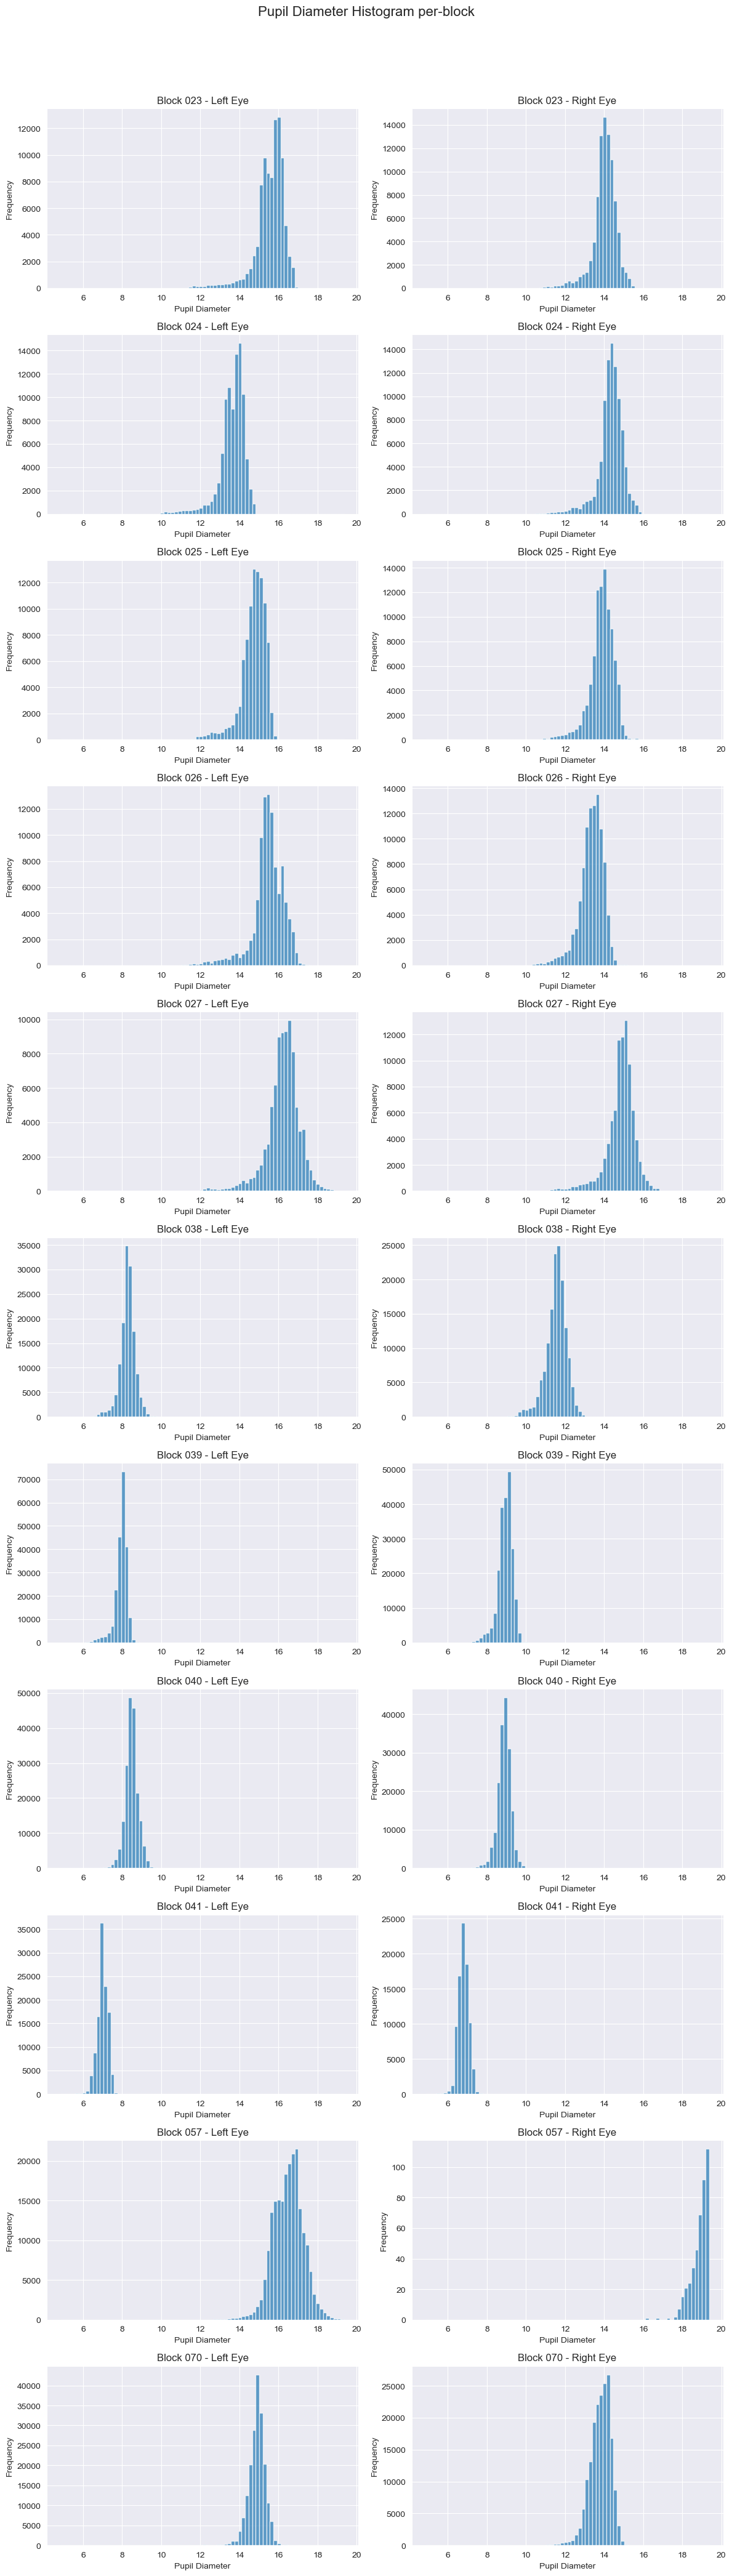

In [112]:
blocks = block_collection
bins = 80
# Determine the overall min and max pupil diameter
extreme_pupil_diameters = []
for block in blocks:
    block_max = np.max(block.left_eye_data['pupil_diameter'].dropna())
    block_min = np.min(block.right_eye_data['pupil_diameter'].dropna())
    print(block, block_max, block_min)
    extreme_pupil_diameters.append(block_max)
    extreme_pupil_diameters.append(block_min)
    
min_diameter = np.min(extreme_pupil_diameters)
max_diameter = np.max(extreme_pupil_diameters)

# Create the figure and subplots
fig, axs = plt.subplots(len(blocks), 2, figsize=(12, 4 * len(blocks)), dpi=100)
fig.suptitle('Pupil Diameter Histogram per-block', fontsize=16)

# Iterate through blocks and plot histograms
for i, block in enumerate(blocks):
    # Left eye histogram
    axs[i, 0].hist(block.left_eye_data['pupil_diameter'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 0].set_title(f'Block {block.block_num} - Left Eye')
    axs[i, 0].set_xlabel('Pupil Diameter')
    axs[i, 0].set_ylabel('Frequency')

    # Right eye histogram
    axs[i, 1].hist(block.right_eye_data['pupil_diameter'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 1].set_title(f'Block {block.block_num} - Right Eye')
    axs[i, 1].set_xlabel('Pupil Diameter')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

PV_62, block 023, on 2023-04-27_10-52-42 305.8016048472885 187.6345012252884
PV_62, block 024, on 2023-04-27_11-22-56 305.8016048472885 187.6345012252884
PV_62, block 025, on 2023-04-27_11-52-05 304.05707072644384 196.99483050853246
PV_62, block 026, on 2023-04-27_12-21-41 316.09006144961256 207.39477845347938
PV_62, block 027, on 2023-04-27_12-53-31 335.95024189508 175.51774311778192
PV_62, block 038, on 2023-05-01_13-57-45 334.4245758590961 191.5805951402367
PV_62, block 039, on 2023-05-01_14-44-23 318.26050518604933 187.71839100256574
PV_62, block 040, on 2023-05-01_15-49-30 333.33975035113644 180.0055942997791
PV_62, block 041, on 2023-05-01_16-58-39 332.56337072714376 194.46499314039642
PV_62, block 057, on 2023-05-08_12-17-49 350.81024289096354 208.22004991361547
PV_62, block 070, on 2023-05-18_14-26-15 341.1018665695712 205.37434390761643


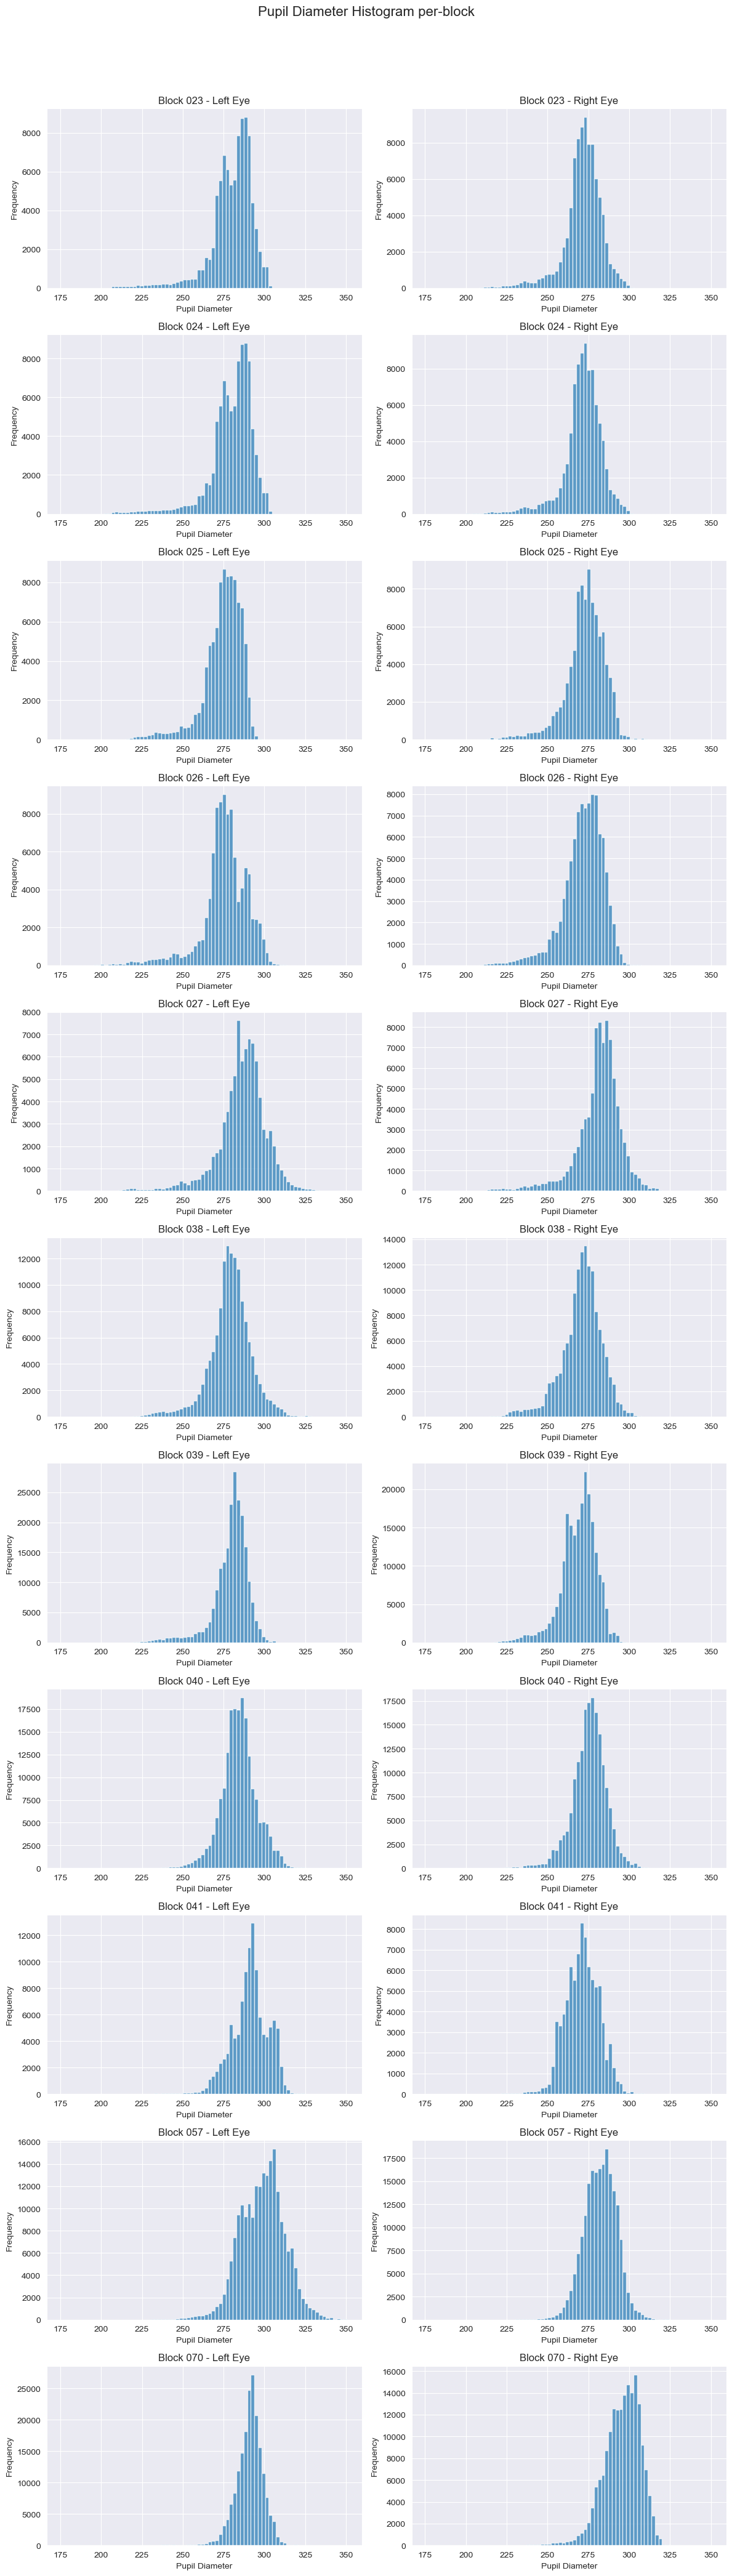

In [113]:
blocks = block_collection
bins = 80
# Determine the overall min and max pupil diameter
extreme_pupil_diameters = []
for block in blocks:
    block_max = np.max(block.left_eye_data['pupil_diameter_pixels'].dropna())
    block_min = np.min(block.right_eye_data['pupil_diameter_pixels'].dropna())
    print(block, block_max, block_min)
    extreme_pupil_diameters.append(block_max)
    extreme_pupil_diameters.append(block_min)
    
min_diameter = np.min(extreme_pupil_diameters)
max_diameter = np.max(extreme_pupil_diameters)

# Create the figure and subplots
fig, axs = plt.subplots(len(blocks), 2, figsize=(12, 4 * len(blocks)), dpi=100)
fig.suptitle('Pupil Diameter Histogram per-block', fontsize=16)

# Iterate through blocks and plot histograms
for i, block in enumerate(blocks):
    # Left eye histogram
    axs[i, 0].hist(block.left_eye_data['pupil_diameter_pixels'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 0].set_title(f'Block {block.block_num} - Left Eye')
    axs[i, 0].set_xlabel('Pupil Diameter')
    axs[i, 0].set_ylabel('Frequency')

    # Right eye histogram
    axs[i, 1].hist(block.right_eye_data['pupil_diameter_pixels'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 1].set_title(f'Block {block.block_num} - Right Eye')
    axs[i, 1].set_xlabel('Pupil Diameter')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:

def get_distance_from_mid(df):
    dx = df['center_x'] - 640/2
    dy = df['center_y'] - 480/2
    r = np.sqrt(dx**2 + dy**2)
    df['distance_from_mid'] = r
    return df

for block in block_collection:
    block.right_eye_data = get_distance_from_mid(block.right_eye_data)
    block.left_eye_data = get_distance_from_mid(block.left_eye_data)



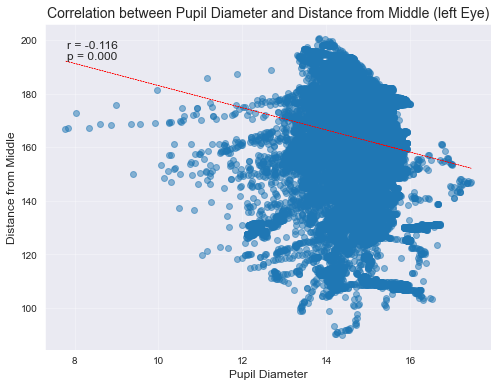

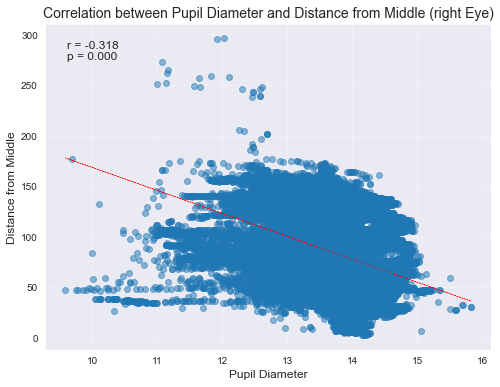

In [16]:


def plot_pupil_size_distance_correlation(block,eye):
    if eye == 'left':
        df = block.left_eye_data
    elif eye == 'right':
        df = block.right_eye_data
    
    valid_data = df.dropna(subset=['pupil_diameter', 'distance_from_mid'])
    correlation, p_value = scipy.stats.pearsonr(valid_data['pupil_diameter'], valid_data['distance_from_mid'])
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(valid_data['pupil_diameter'], valid_data['distance_from_mid'], alpha=0.5)
    
    # Set labels, title, and add regression line
    plt.xlabel('Pupil Diameter', fontsize=12)
    plt.ylabel('Distance from Middle', fontsize=12)
    plt.title(f'Correlation between Pupil Diameter and Distance from Middle ({eye} Eye)', fontsize=14)
    
    z = np.polyfit(valid_data['pupil_diameter'], valid_data['distance_from_mid'], 1)
    p = np.poly1d(z)
    plt.plot(valid_data['pupil_diameter'],p(valid_data['pupil_diameter']),"r--", linewidth=0.5)
    
    # Annotate with correlation coefficient and p-value
    text = f'r = {correlation:.3f}\np = {p_value:.3f}'
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')
    
    plt.grid(alpha=0.4)
    plt.show()
plot_pupil_size_distance_correlation(block,'left')
plot_pupil_size_distance_correlation(block,'right')

In [105]:
# This is a preliminary version of the psd calculation function
neuro_data_list = []
neuro_timestamp_list = []
for segment in tqdm.tqdm(pupil_small_chunks):
    start_time = segment[0]
    seg_length = segment[1]
    neuro_data, neuro_timestamps = block.oe_rec.get_data(channels= [15],
                                                         start_time_ms=[start_time],
                                                         window_ms = [seg_length],
                                                         convert_to_mv=True,
                                                         return_timestamps=True)
    neuro_data_list.append(neuro_data)
    neuro_timestamp_list.append(neuro_timestamps)
    

 84%|████████▎ | 41/49 [00:00<00:00, 122.57it/s]

sample removed for window #0
The requested data segment between 19222 ms and [[20954.45]] ms exceeds the recording length, and will be 0-padded to fit the other windows
The requested data segment between 19427 ms and [[20582.35]] ms exceeds the recording length, and will be 0-padded to fit the other windows
sample removed for window #0
The requested data segment between 23688 ms and [[35284.4]] ms exceeds the recording length, and will be 0-padded to fit the other windows
The requested data segment between 26302 ms and [[29801.95]] ms exceeds the recording length, and will be 0-padded to fit the other windows
sample removed for window #0


100%|██████████| 49/49 [00:00<00:00, 126.40it/s]


In [59]:
def find_consistent_pupil_windows(block, eye, threshold=1.2, min_duration=10000):
    """Finds time windows where pupil diameter z-score consistently meets a threshold.

    Args:
        block: The block object containing eye data.
        eye: String indicating which eye ('left' or 'right').
        threshold: The z-score threshold (positive for above, negative for below).
        min_duration: Minimum duration of the window in milliseconds.

    Returns:
        list: A list of tuples (start_time, end_time) in milliseconds for valid windows.
    """
    if eye == 'left':
        df = block.left_eye_data
    elif eye == 'right':
        df = block.right_eye_data
    
    df = get_zscored_column(df.copy(), 'pupil_diameter')

    valid_windows = []
    current_window_start = None

    for i, row in df.iterrows():
        zscore = row['pupil_diameter_zscore']
        time = row['ms_axis']

        condition_met = (threshold > 0 and zscore > threshold) or (threshold < 0 and zscore < threshold)

        if condition_met:
            if current_window_start is None:
                current_window_start = time
            # Check if the current window is valid and append
            if time - current_window_start >= min_duration:
                valid_windows.append((current_window_start, time))
                current_window_start = None  # Reset to find the next window
        else:
            current_window_start = None  # Reset if condition not met

    return valid_windows


above_threshold_windows = find_consistent_pupil_windows(block, 'left', 1.2, 10000)
below_threshold_windows = find_consistent_pupil_windows(block, 'right', -1.2, 10000)

In [60]:
below_threshold_windows

[(341552.8, 351556.3)]

In [20]:
  
start_ts = block.all_saccade_df.query('eye == "R" and length==4')['saccade_start_timestamp'] - ((block.sample_rate / 58)*5)
end_ts = block.all_saccade_df.query('eye == "R" and length==4')['saccade_end_timestamp'] + ((block.sample_rate / 58)*5)
angles = block.all_saccade_df.query('eye == "R" and length==4')['angle']
df = block.right_eye_data
# Initialize an empty list to store the pupil diameter arrays
pupil_diameter_array = []
pupil_pixel_array = []
# Iterate over pairs of start_ts and end_ts
for start, end in zip(start_ts, end_ts):
    # Filter df based on OE_timestamp between start and end
    filtered_df = df[(df['OE_timestamp'] >= start) & (df['OE_timestamp'] <= end)]
    
    # Extract pupil diameter values
    pupil_diameter_values = filtered_df['pupil_diameter'].values
    mean = np.nanmean(pupil_diameter_values)
    std = np.nanstd(pupil_diameter_values)
    pupil_diameter_values = (pupil_diameter_values - mean) / std
    pupil_pixel_values = filtered_df['pupil_diameter_pixels']
    mean = np.nanmean(pupil_pixel_values)
    std = np.nanstd(pupil_pixel_values)
    pupil_pixel_values = (pupil_pixel_values - mean) / std
    pupil_diameter_array.append(pupil_diameter_values)
    pupil_pixel_array.append(pupil_pixel_values)
# Convert the list of arrays to a numpy array
pupil_diameter_array = np.array(pupil_diameter_array)
pupil_pixel_array = np.array(pupil_pixel_array)

In [31]:
# Initialize empty lists for left and right eye DataFrames
all_pupil_data_left = []
all_pupil_data_right = []

# Iterate over the blocks in the dictionary
for block_number, block in block_dict.items():
    for eye in ['R', 'L']:
        eye_data = block.right_eye_data if eye == 'R' else block.left_eye_data
        start_ts = block.all_saccade_df.query(f'eye == "{eye}" and length==4')['saccade_start_timestamp'] - ((block.sample_rate / 58)*5)
        end_ts = block.all_saccade_df.query(f'eye == "{eye}" and length==4')['saccade_end_timestamp'] + ((block.sample_rate / 58)*5)

        # Initialize an empty list to store pupil diameter arrays for this block and eye
        pupil_diameter_arrays = []
        pupil_pixel_arrays = []
        
        for start, end in zip(start_ts, end_ts):
            filtered_df = eye_data[(eye_data['OE_timestamp'] >= start) & (eye_data['OE_timestamp'] <= end)]

            # Extract and standardize pupil data
            pupil_diameter_values = filtered_df['pupil_diameter'].values
            mean = np.nanmean(pupil_diameter_values)
            std = np.nanstd(pupil_diameter_values)
            pupil_diameter_values = (pupil_diameter_values - mean) / std
            
            pupil_pixel_values = filtered_df['pupil_diameter_pixels'].values
            mean = np.nanmean(pupil_pixel_values)
            std = np.nanstd(pupil_pixel_values)
            pupil_pixel_values = (pupil_pixel_values - mean) / std

            # Append to the array list
            pupil_diameter_arrays.append(pupil_diameter_values)
            pupil_pixel_arrays.append(pupil_pixel_values)

        # Create a DataFrame for this block and eye
        block_pupil_data = pd.DataFrame({
            'pupil_diameter_array': pupil_diameter_arrays,
            'pupil_pixel_array': pupil_pixel_arrays,
            'block_number': block_number,
        })

        # Append to the correct list based on the eye
        if eye == 'L':
            all_pupil_data_left.append(block_pupil_data)
        else:
            all_pupil_data_right.append(block_pupil_data)
            

# Concatenate all DataFrames into separate left and right DataFrames
combined_pupil_df_left = pd.concat(all_pupil_data_left, ignore_index=True)
combined_pupil_df_right = pd.concat(all_pupil_data_right, ignore_index=True)

# Reset Index to ensure the order of the concatenated results.
combined_pupil_df_left.reset_index(drop=True, inplace=True)
combined_pupil_df_right.reset_index(drop=True, inplace=True)




In [40]:
pupil_diameter_array_right = np.vstack(combined_pupil_df_right.pupil_diameter_array)
pupil_diameter_array_left = np.vstack(combined_pupil_df_left.pupil_diameter_array)

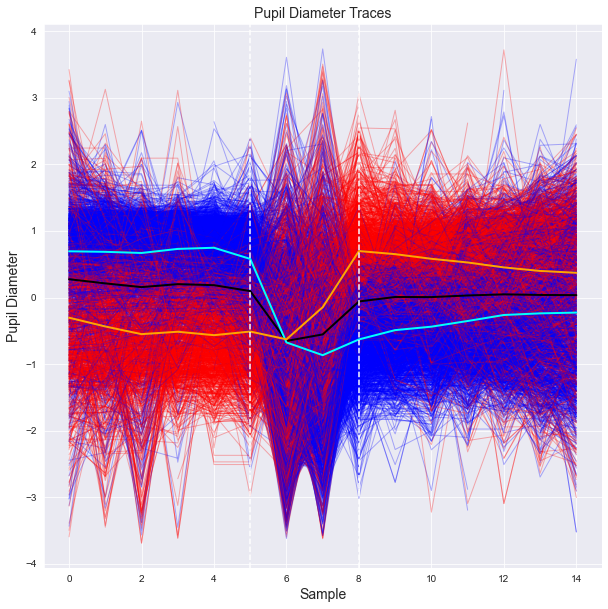

In [42]:
# right eye plot:
# Calculate row-wise average
plt.figure(figsize=(10, 10))
row_avg = np.nanmean(pupil_diameter_array_right, axis=0)

# Plot individual traces
positive_avg_arr = []
negative_avg_arr = []
for i, trace in enumerate(pupil_diameter_array_right):
    
    pupil_change = trace[4] - trace[8]
    if pupil_change > 0:
        plt.plot(trace, color='blue', alpha=0.3, linewidth=1)
        positive_avg_arr.append(trace)
    if pupil_change < 0:
        plt.plot(trace, color='red', alpha=0.3, linewidth=1)
        negative_avg_arr.append(trace)


# Plot row-wise average in bold
positive_avg = np.nanmean(positive_avg_arr,axis=0)
negative_avg = np.nanmean(negative_avg_arr,axis=0)
plt.plot(row_avg, color='black', linewidth=2)
plt.plot(positive_avg, color='cyan', linewidth=2)
plt.plot(negative_avg, color='orange', linewidth=2)

# Draw horizontal line at sample 5
plt.axvline(x=5, color='white', linestyle='--')
plt.axvline(x=8, color='white', linestyle='--')
# Add labels and legend
plt.xlabel('Sample', fontsize=14)

plt.ylabel('Pupil Diameter', fontsize=14)
plt.title('Pupil Diameter Traces', fontsize=14)
#plt.legend(fontsize=14)

# Show plot
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_pupil_diameter_flux.pdf', format='pdf')
plt.show()

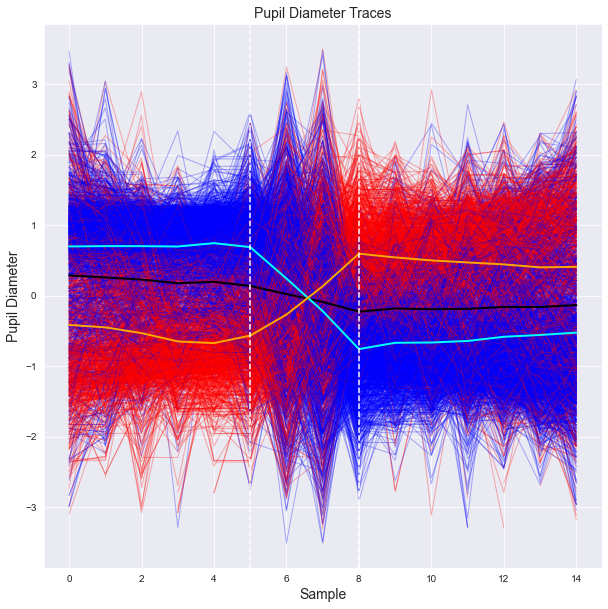

In [43]:
# left eye plot:
# Calculate row-wise average
plt.figure(figsize=(10, 10))
row_avg = np.nanmean(pupil_diameter_array_left, axis=0)

# Plot individual traces
positive_avg_arr = []
negative_avg_arr = []
for i, trace in enumerate(pupil_diameter_array_left):
    
    pupil_change = trace[4] - trace[8]
    if pupil_change > 0:
        plt.plot(trace, color='blue', alpha=0.3, linewidth=1)
        positive_avg_arr.append(trace)
    if pupil_change < 0:
        plt.plot(trace, color='red', alpha=0.3, linewidth=1)
        negative_avg_arr.append(trace)


# Plot row-wise average in bold
positive_avg = np.nanmean(positive_avg_arr,axis=0)
negative_avg = np.nanmean(negative_avg_arr,axis=0)
plt.plot(row_avg, color='black', linewidth=2)
plt.plot(positive_avg, color='cyan', linewidth=2)
plt.plot(negative_avg, color='orange', linewidth=2)

# Draw horizontal line at sample 5
plt.axvline(x=5, color='white', linestyle='--')
plt.axvline(x=8, color='white', linestyle='--')
# Add labels and legend
plt.xlabel('Sample', fontsize=14)

plt.ylabel('Pupil Diameter', fontsize=14)
plt.title('Pupil Diameter Traces', fontsize=14)
#plt.legend(fontsize=14)

# Show plot
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_pupil_diameter_flux.pdf', format='pdf')
plt.show()

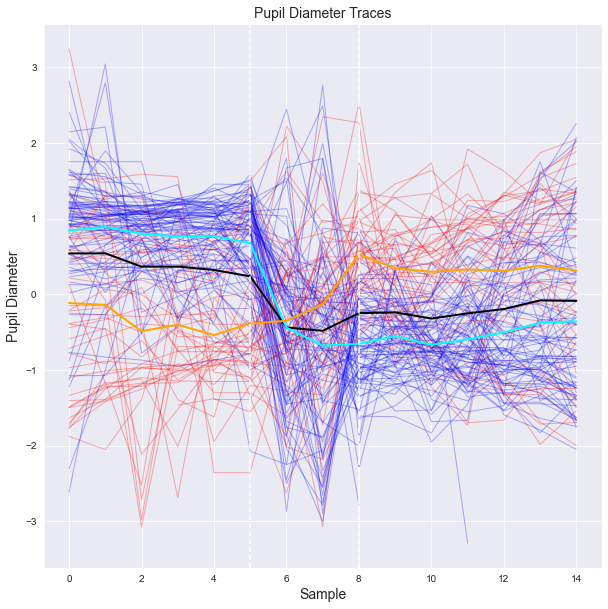

In [102]:
# Calculate row-wise average
plt.figure(figsize=(10, 10))
row_avg = np.nanmean(pupil_pixel_array, axis=0)

# Plot individual traces
positive_avg_arr = []
negative_avg_arr = []
for i, trace in enumerate(pupil_pixel_array):
    
    pupil_change = trace[4] - trace[8]
    if pupil_change > 0:
        plt.plot(trace, color='blue', alpha=0.3, linewidth=1)
        positive_avg_arr.append(trace)
    if pupil_change < 0:
        plt.plot(trace, color='red', alpha=0.3, linewidth=1)
        negative_avg_arr.append(trace)


# Plot row-wise average in bold
positive_avg = np.nanmean(positive_avg_arr,axis=0)
negative_avg = np.nanmean(negative_avg_arr,axis=0)
plt.plot(row_avg, color='black', linewidth=2)
plt.plot(positive_avg, color='cyan', linewidth=2)
plt.plot(negative_avg, color='orange', linewidth=2)

# Draw horizontal line at sample 5
plt.axvline(x=5, color='white', linestyle='--')
plt.axvline(x=8, color='white', linestyle='--')
# Add labels and legend
plt.xlabel('Sample', fontsize=14)

plt.ylabel('Pupil Diameter', fontsize=14)
plt.title('Pupil Diameter Traces', fontsize=14)
#plt.legend(fontsize=14)

# Show plot
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_pupil_diameter_flux_pixels_version.pdf', format='pdf')
plt.show()

In [52]:
saccade_collection

saccade_start_ind  saccade_start_timestamp  saccade_end_ind  \
0                   144                 654010.0              147   
1                   314                 711765.0              317   
2                   317                 712784.0              320   
3                   389                 737247.0              394   
4                   481                 768501.0              485   
...                 ...                      ...              ...   
3202             211495               72471496.0           211498   
3203             211506               72475231.0           211508   
3204             211539               72486436.0           211543   
3205             211766               72563528.0           211768   
3206             212085               72671865.0           212091   

      saccade_end_timestamp  length  magnitude       angle   initial_x  \
0                  655030.0       3   0.534393  176.702171  347.488436   
1                  712784.0       3   0.755933   26.687813  344.155545   
2                  713804.0       3   0.479191   29.579500  356.268503   
3                  738946.0       5   2.822236   20.148744  361.929025   
4                  769860.0       4   1.504222   31.824127  397.479600   
...                     ...     ...        ...         ...         ...   
3202             72472515.0       3   0.798482  173.662014  409.275105   
3203             72475910.0       2   1.674139  321.483306  395.137330   
3204             72487795.0       4   1.275621   60.217011  407.841581   
3205             72564207.0       2   0.273223   41.958958  409.886511   
3206             72673902.0       6   1.920701  279.843172  413.816352   

       initial_y       end_x       end_y  calib_dx  calib_dy eye block  
0     184.848718  339.538938  185.306781 -0.441796  0.025457   L   023  
1     170.567144  356.268503  176.656100  0.673181  0.338395   L   023  
2     176.656100  362.450243  180.164892  0.343552  0.195002   L   023  
3     185.908815  407.992317  202.810036  2.559981  0.939290   L   023  
4     192.794077  419.724135  206.599244  1.236246  0.767226   L   023  
...          ...         ...         ...       ...       ...  ..   ...  
3202  176.947936  401.144076  177.851067 -0.634134  0.070435   R   057  
3203  178.816874  411.423521  165.854503  1.270151 -1.010928   R   057  
3204  165.650504  415.624797  179.250126  0.607009  1.060627   R   057  
3205  176.665726  412.017300  178.581535  0.166179  0.149413   R   057  
3206  178.752308  417.633609  156.751600  0.297706 -1.715823   R   057  

[30146 rows x 15 columns]

In [48]:
block.left_eye_data.speed_y

0              NaN
1        -0.035394
2        -0.196599
3        -0.138980
4        -0.046849
            ...   
212322    0.034110
212323    0.943533
212324    0.012297
212325    0.031766
212326   -0.044292
Name: speed_y, Length: 212327, dtype: float64

In [15]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df
synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [16]:
# analyze synced saccades into categories
conjunctive_angle_threshold = 45
for i, group in tqdm.tqdm(synced_saccade_collection.groupby('Main')):
    if len(group) != 2:
        print('something wrong',i)
        break
    l_angle = group[group['Sub'] == 'L'].angle.values    
    r_angle = group[group['Sub'] == 'R'].angle.values
    
    # check for missing angle values:
    if l_angle != l_angle or r_angle != r_angle:
        print(i,'has missing values')
        print(r_angle,l_angle)
        continue
    # check for conjunctive saccades = the movements in each eye have the same amplitude and direction
    if abs(l_angle - r_angle) < conjunctive_angle_threshold:
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = True
    else:
        # Set the 'conjunctive' column to False for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = False
    
    # tag convergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= l_angle <= 270) and (r_angle >= 270 or r_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = False
    
    # tag divergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= r_angle <= 270) and (l_angle >= 270 or l_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = False
        
    

100%|██████████| 8511/8511 [01:14<00:00, 114.41it/s]


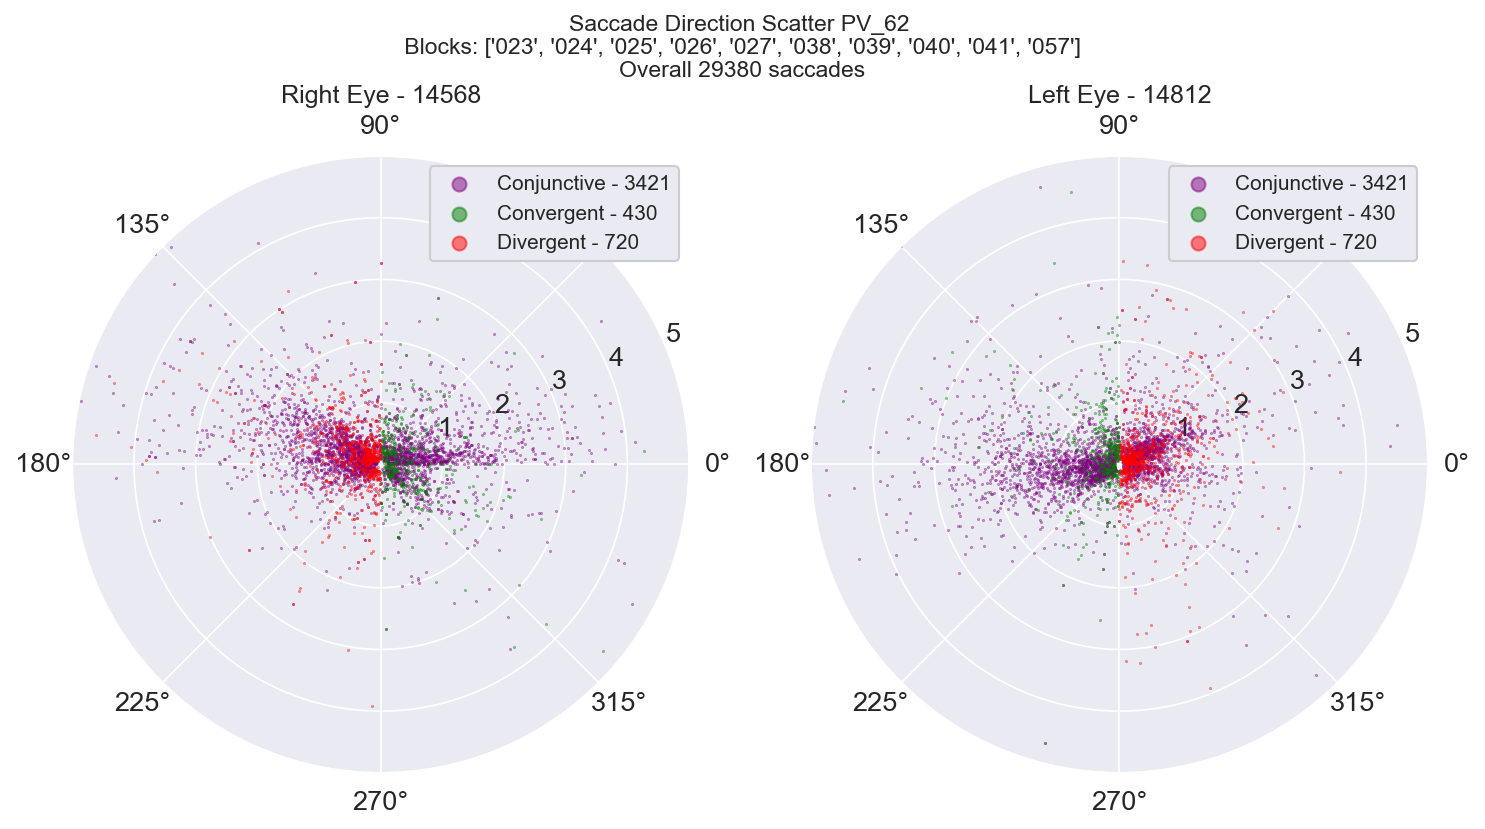

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_saccade_directions_old(synced_saccade_collection, non_synced_saccade_collection, block, block_collection, export_path=False):
    font_size = 13
    
    synced_saccades_r = synced_saccade_collection.query('eye == "R"')
    non_synced_saccades_r = non_synced_saccade_collection.query('eye == "R"')
    synced_saccades_l = synced_saccade_collection.query('eye == "L"')
    non_synced_saccades_l = non_synced_saccade_collection.query('eye == "L"')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
    fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
                 f'Blocks: {[b.block_num for b in block_collection]} \n'
                 f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
                 fontsize=font_size - 2, y=1)

    colors = {'conjunctive': 'purple', 'convergent': 'green', 'divergent': 'red', 'non-synced': 'blue'}

    for ax, eye, synced_saccades, non_synced_saccades in zip(axs, ['Right', 'Left'], 
                                                             [synced_saccades_r, synced_saccades_l], 
                                                             [non_synced_saccades_r, non_synced_saccades_l]):
        # ax.scatter(np.deg2rad(list(non_synced_saccades.angle.values.astype(int))),
        #            non_synced_saccades.magnitude.values,
        #            color=colors['non-synced'], 
        #            alpha=0.5, 
        #            s=0.2, 
        #            label=f'Non-Synced {len(non_synced_saccades)}')
        
        for saccade_type, color in colors.items():
            if saccade_type in synced_saccades.columns:
                ax.scatter(np.deg2rad(list(synced_saccades[synced_saccades[saccade_type] == True].angle.values.astype(int))),
                           synced_saccades[synced_saccades[saccade_type] == True].magnitude.values,
                           color=color, 
                           alpha=0.5, 
                           s=0.2, 
                           label=f'{saccade_type.capitalize()} - {len(synced_saccades[synced_saccades[saccade_type] == True].magnitude.values)}')


        ax.grid(True)
        ax.tick_params(axis='both', labelsize=font_size)
        ax.set_ylim(0, 5)
        ax.set_title(f'{eye} Eye - {len(synced_saccades) + len(non_synced_saccades)}', y=1)
        ax.legend(loc='upper right', scatterpoints=1, markerscale=15, framealpha=1)

    plt.tight_layout()
    if export_path is not False:
        plt.savefig(export_path,format='pdf')
    plt.show()
    return
def plot_saccade_directions_angles(synced_saccade_collection, non_synced_saccade_collection, block, block_collection, export_path=False):
    font_size = 13
    
    synced_saccades_r = synced_saccade_collection.query('eye == "R"')
    non_synced_saccades_r = non_synced_saccade_collection.query('eye == "R"')
    synced_saccades_l = synced_saccade_collection.query('eye == "L"')
    non_synced_saccades_l = non_synced_saccade_collection.query('eye == "L"')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
    fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
                 f'Blocks: {[b.block_num for b in block_collection]} \n'
                 f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
                 fontsize=font_size - 2, y=1)

    colors = {'conjunctive': 'purple', 'convergent': 'green', 'divergent': 'red', 'non-synced': 'blue'}

    for ax, eye, synced_saccades, non_synced_saccades in zip(axs, ['Right', 'Left'], 
                                                             [synced_saccades_r, synced_saccades_l], 
                                                             [non_synced_saccades_r, non_synced_saccades_l]):
        # ax.scatter(np.deg2rad(list(non_synced_saccades.angle.values.astype(int))),
        #            non_synced_saccades.magnitude.values,
        #            color=colors['non-synced'], 
        #            alpha=0.5, 
        #            s=0.2, 
        #            label=f'Non-Synced {len(non_synced_saccades)}')
        
        for saccade_type, color in colors.items():
            if saccade_type in synced_saccades.columns:
                ax.scatter(np.deg2rad(list(synced_saccades[synced_saccades[saccade_type] == True].angle.values.astype(int))),
                           synced_saccades[synced_saccades[saccade_type] == True].magnitude.values,
                           color=color, 
                           alpha=0.5, 
                           s=0.2, 
                           label=f'{saccade_type.capitalize()} - {len(synced_saccades[synced_saccades[saccade_type] == True].magnitude.values)}')


        ax.grid(True)
        ax.tick_params(axis='both', labelsize=font_size)
        ax.set_ylim(0, 5)
        ax.set_title(f'{eye} Eye - {len(synced_saccades) + len(non_synced_saccades)}', y=1)
        ax.legend(loc='upper right', scatterpoints=1, markerscale=15, framealpha=1)

    plt.tight_layout()
    if export_path is not False:
        plt.savefig(export_path,format='pdf')
    plt.show()
    return

# Usage example:
block = block_collection[0]
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_types_noMono.pdf'
plot_saccade_directions_old(synced_saccade_collection, non_synced_saccade_collection, block, block_collection, export_path=False)


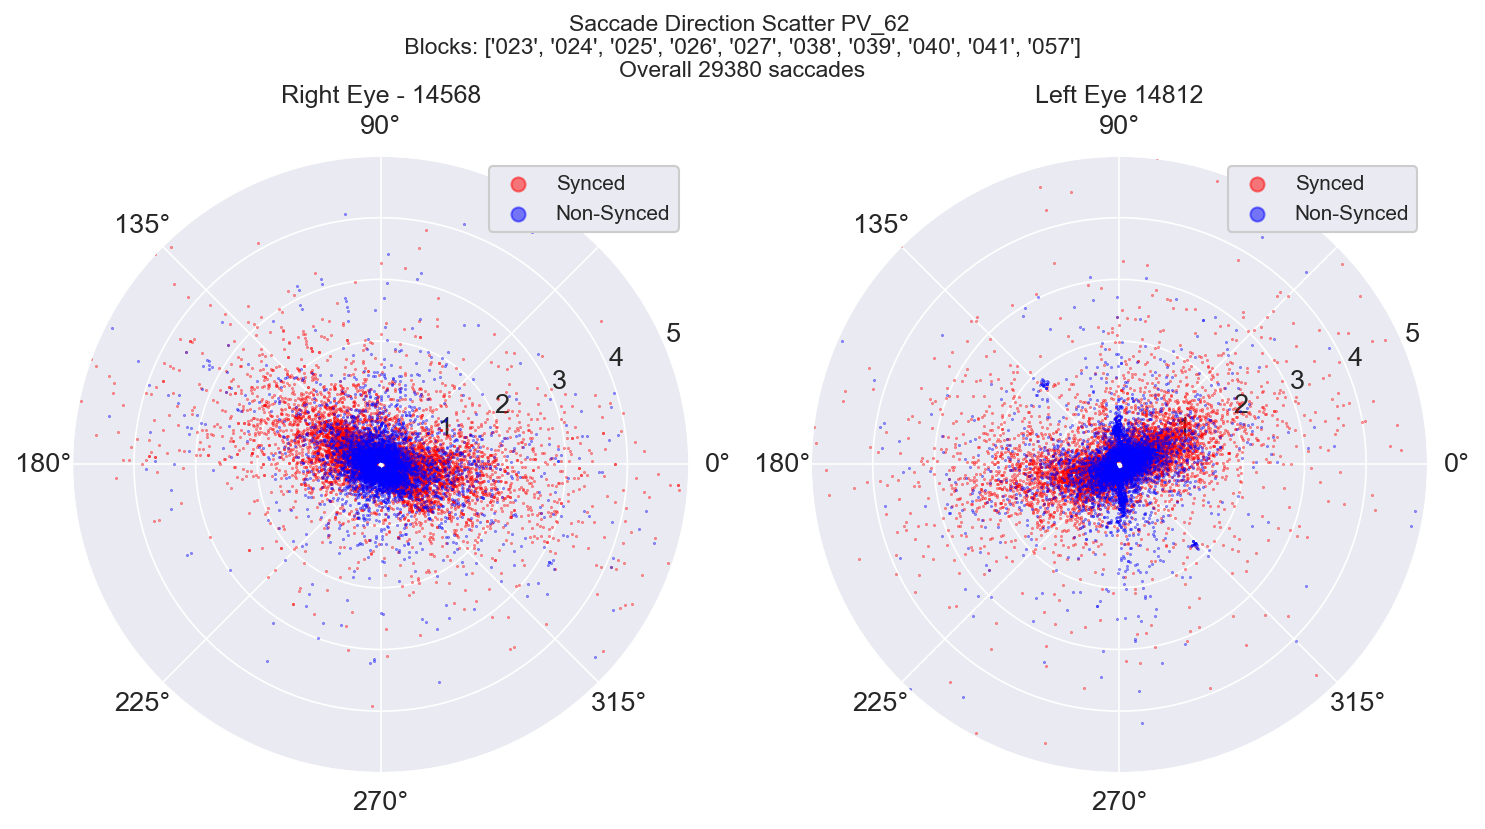

In [20]:
# Assuming you have saccade_collection and block defined somewhere in your code

font_size = 13
num_bins = 36
synced_saccades_r = synced_saccade_collection.query('eye == "R"')
non_synced_saccades_r = non_synced_saccade_collection.query('eye == "R"')
synced_saccades_l = synced_saccade_collection.query('eye == "L"')
non_synced_saccades_l = non_synced_saccade_collection.query('eye == "L"')


fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
             fontsize=font_size - 2, y=1)

axs[0].scatter(np.deg2rad(list(synced_saccades_r.angle.values.astype(int))), synced_saccades_r.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[0].scatter(np.deg2rad(list(non_synced_saccades_r.angle.values.astype(int))), non_synced_saccades_r.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')
axs[1].scatter(np.deg2rad(list(synced_saccades_l.angle.values.astype(int))), synced_saccades_l.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[1].scatter(np.deg2rad(list(non_synced_saccades_l.angle.values.astype(int))), non_synced_saccades_l.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')

for ax, title in zip(axs,[f'Right Eye - {len(synced_saccades_r) + len(non_synced_saccades_r)}',
                          f'Left Eye {len(synced_saccades_l) + len(non_synced_saccades_l)}']):
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    #ax.set_yticks([])
    ax.set_ylim(0,5)
    ax.set_title(title, y=1)
    ax.legend(loc='upper right',scatterpoints=1, markerscale=15, framealpha=1)
    #ax.set_ylabel('[mm]')

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_Synced_and_non_synced.pdf', format='pdf')
plt.show()

In [109]:

def export_eyetracking_video(block, start_ms_list, end_ms_list, xflip=True, yrotate=True, rotate_frames=True, export_path=None):
    if export_path is None:
        print('No export path supplied, use a show_eye_videos')
    le_vid = block.le_videos[0]
    re_vid = block.re_videos[0]

    if len(start_ms_list) != len(end_ms_list):
        print("Error: The number of start_ms values must be equal to the number of end_ms values.")
        return
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    output_video = cv2.VideoWriter(str(export_path),fourcc, 60.0, (640*2,480*2))
    le_cap = cv2.VideoCapture(le_vid)
    re_cap = cv2.VideoCapture(re_vid)

    if not le_cap.isOpened() or not re_cap.isOpened():
        print("Error opening video file.")
        return
    
    prev_l_frame = 0
    prev_r_frame = 0
    stop_flag = False
    for i, (start_ms, end_ms) in tqdm.tqdm(enumerate(zip(start_ms_list, end_ms_list))):
        if stop_flag:
            break
        if block.left_eye_data.iloc[0].ms_axis > start_ms:
            print(f'ms_axis starts at {block.left_eye_data.iloc[0].ms_axis} but {start_ms} was requested, defaulting to earliest sample')
            start_ms = block.left_eye_data.iloc[0].ms_axis
        if block.left_eye_data.iloc[-1].ms_axis < end_ms:
            print(f'ms_axis ends at {block.left_eye_data.iloc[-1].ms_axis} but {end_ms} was requested, defaulting to last sample')
            end_ms = block.left_eye_data.iloc[-1].ms_axis

        ms_timestamps = block.left_eye_data.query('ms_axis > @start_ms and ms_axis < @end_ms')['ms_axis'].values
        
        # insert a completely white frame segment of 0.5 seconds (30 frames)
        for current_ms in ms_timestamps:
            current_le_frame = int(block.left_eye_data.query('ms_axis == @current_ms').eye_frame)
            current_re_frame = int(block.right_eye_data.query('ms_axis == @current_ms').eye_frame)

            if prev_l_frame + 1 != current_le_frame:
                le_cap.set(cv2.CAP_PROP_POS_FRAMES, current_le_frame)
            l_ret, l_frame = le_cap.read()

            if prev_r_frame + 1 != current_re_frame:
                re_cap.set(cv2.CAP_PROP_POS_FRAMES, current_re_frame)
            r_ret, r_frame = re_cap.read()

            if not r_ret or not l_ret:
                break

            if xflip:
                l_frame = cv2.flip(l_frame, 1)
                r_frame = cv2.flip(r_frame, 1)
            
            if rotate_frames:
                if block.left_rotation_matrix is None or block.right_rotation_matrix is None:
                    raise AttributeError('At least one rotation matrix is missing... \n '
                                         'Run the rotate_frame_to_horizontal_with_interpolation for each eye video')
                else:
                    l_frame = cv2.warpAffine(l_frame, block.left_rotation_matrix, (l_frame.shape[1], l_frame.shape[0]))
                    r_frame = cv2.warpAffine(r_frame, block.right_rotation_matrix, (r_frame.shape[1], r_frame.shape[0]))
            # if you want to plot something on the frame, do it before rotation and rotate the annotated frame
            if yrotate:
                l_frame = cv2.rotate(l_frame, cv2.ROTATE_180)
                r_frame = cv2.rotate(r_frame, cv2.ROTATE_180)
                
            synchronized_frame = cv2.hconcat([r_frame, l_frame])
            
            # Add a black lower section to the frame
            synchronized_frame = cv2.cvtColor(synchronized_frame, cv2.COLOR_BGR2GRAY)
            
            black_section = np.zeros((l_frame.shape[0], l_frame.shape[1]*2, 3), dtype=np.uint8)
            black_section = cv2.cvtColor(black_section, cv2.COLOR_BGR2GRAY)
            
            synchronized_frame = np.vstack([synchronized_frame, black_section])
            # Write current_ms value in the added black area
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(synchronized_frame, f'Millisecond timestamp: {current_ms}', (10, l_frame.shape[0] + 30),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(synchronized_frame, f'saccade_number: {i}', (10, l_frame.shape[0] + 60),
                        font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            #print(f'frame actual size: {np.shape(synchronized_frame)}')
            output_video.write(synchronized_frame)
            prev_l_frame = current_le_frame
            prev_r_frame = current_re_frame
        # add half second white blink for saccade ends:
        if synchronized_frame is not None:
            for wb in range(5):
                output_video.write(np.ones_like(synchronized_frame)*1)
                # key = cv2.waitKey(25)
                # if key == ord('q'):
                #     stop_flag = True
                #     break
                # elif key == ord('n'):
                #     break
    output_video.release()
    le_cap.release()
    re_cap.release()
    cv2.destroyAllWindows()
    
    
clip_start = saccade_collection.query('synced_saccade==True and block == "038"').saccade_start_timestamp.values
df = block_dict['038'].left_eye_data[['OE_timestamp','ms_axis']]
clip_start_ms = np.unique(df[df.OE_timestamp.isin(clip_start)]['ms_axis'].values) - 500
clip_end_ms = np.unique(df[df.OE_timestamp.isin(clip_start)]['ms_axis'].values)+ 500
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
p = pathlib.Path(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_collection_for_test.mp4')


export_eyetracking_video(block_dict['038'], clip_start_ms[:40], clip_end_ms[:40],export_path=p)

40it [00:28,  1.39it/s]


In [16]:
# pad speed profiles for shorter saccades
# Find the maximum length
max_length = max(len(profile) for profile in saccade_collection['speed_profile'])
# Create an array filled with NaNs of the maximum length
padded_profiles = np.full((len(saccade_collection), max_length), np.nan)

# Fill in the values from each profile
for i, profile in enumerate(saccade_collection['speed_profile']):
    padded_profiles[i, :len(profile)] = profile

# Calculate the mean ignoring nan values
average_profile = np.nanmean(padded_profiles, axis=0)

# Plot individual speed profiles
fig, axs = plt.subplots(figsize=(7, 4), dpi=150)
for row in tqdm.tqdm(padded_profiles):
    axs.plot(row[:7], alpha=0.1)


# Plot average speed profile in a bolder line
axs.plot(average_profile[:7], label=f'Average Profile \n Saccade Count = {len(padded_profiles)}', linewidth=2, color='black')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.title('Speed Profiles and Average Profile')

# Show the plot
plt.show()

KeyError: 'speed_profile'

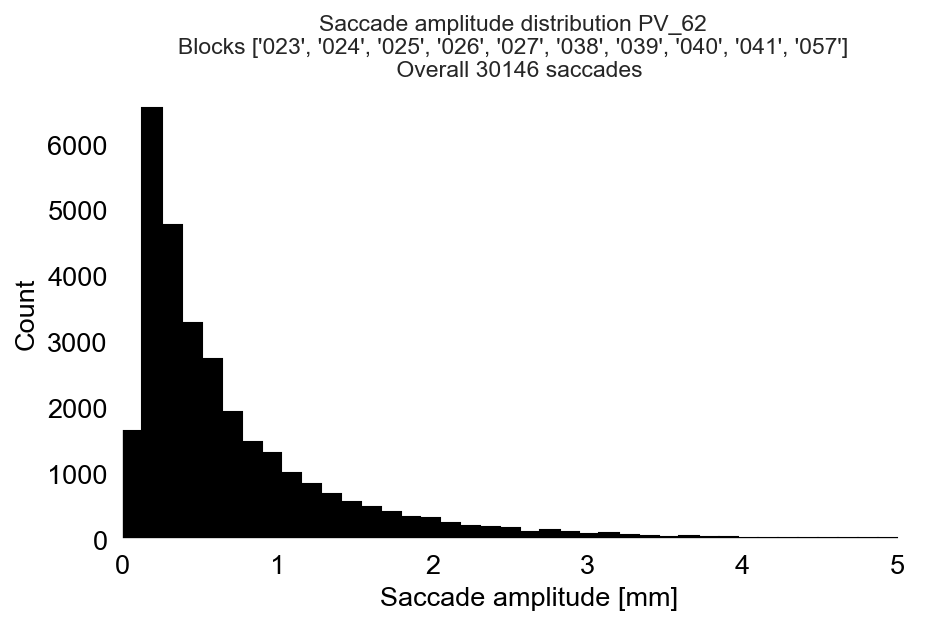

In [21]:
from scipy.stats import poisson
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
all_magnitudes_mm = saccade_collection['magnitude'].values
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(all_magnitudes_mm,bins=np.linspace(0,5,40),log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Saccade amplitude distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(all_magnitudes_mm)} saccades')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')



t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_amplitude_distribution.pdf', format='pdf')
plt.show()

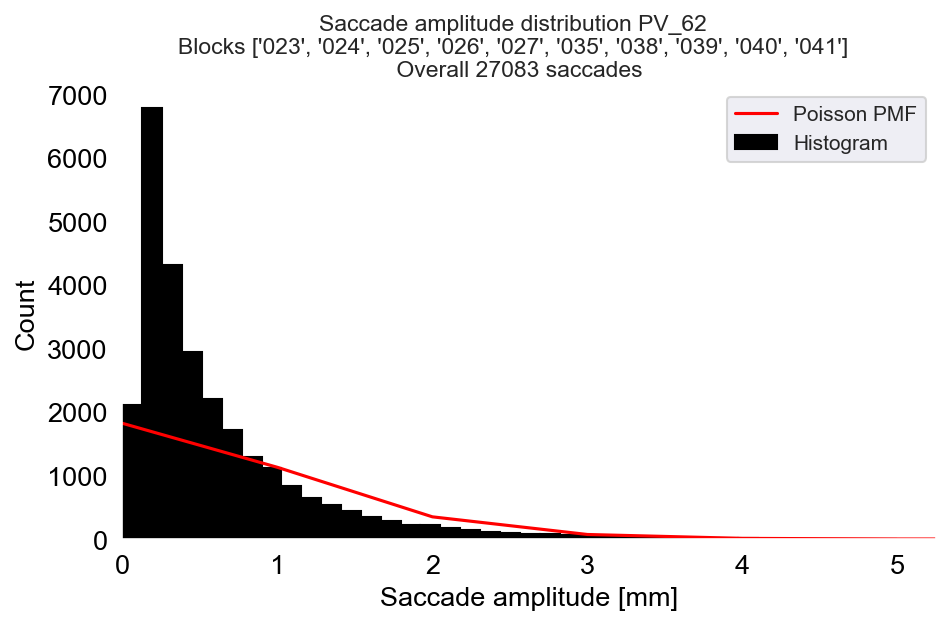

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import datetime

# Assuming you have a dataset x_values
# Replace this with your actual dataset
x_values = saccade_collection['magnitude'].values

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(x_values, bins=np.linspace(0, 5, 40), log=True, color='black', edgecolor='black', label='Histogram')

# Set title and labels
title = (f'Saccade amplitude distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(x_values)} saccades')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')


# Generate x values for plotting
x_plot = np.arange(0, max(x_values) + 1)

# Calculate the first four moments
x_values = all_magnitudes_mm
mu = np.mean(x_values)
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

# Display the probability mass function (pmf)
x_plot = np.arange(0, max(x_values) + 1)
poisson_pmf = poisson.pmf(x_plot, mu)
# Calculate the PMF for each x value


# Plot the Poisson distribution pmf
ax.plot(x_plot, poisson_pmf * len(x_values) * (5 / 40), 'r-', label='Poisson PMF')

# Add legend
ax.legend()

t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
# Uncomment the line below to save the figure
# plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_amplitude_distribution.pdf', format='pdf')
plt.show()


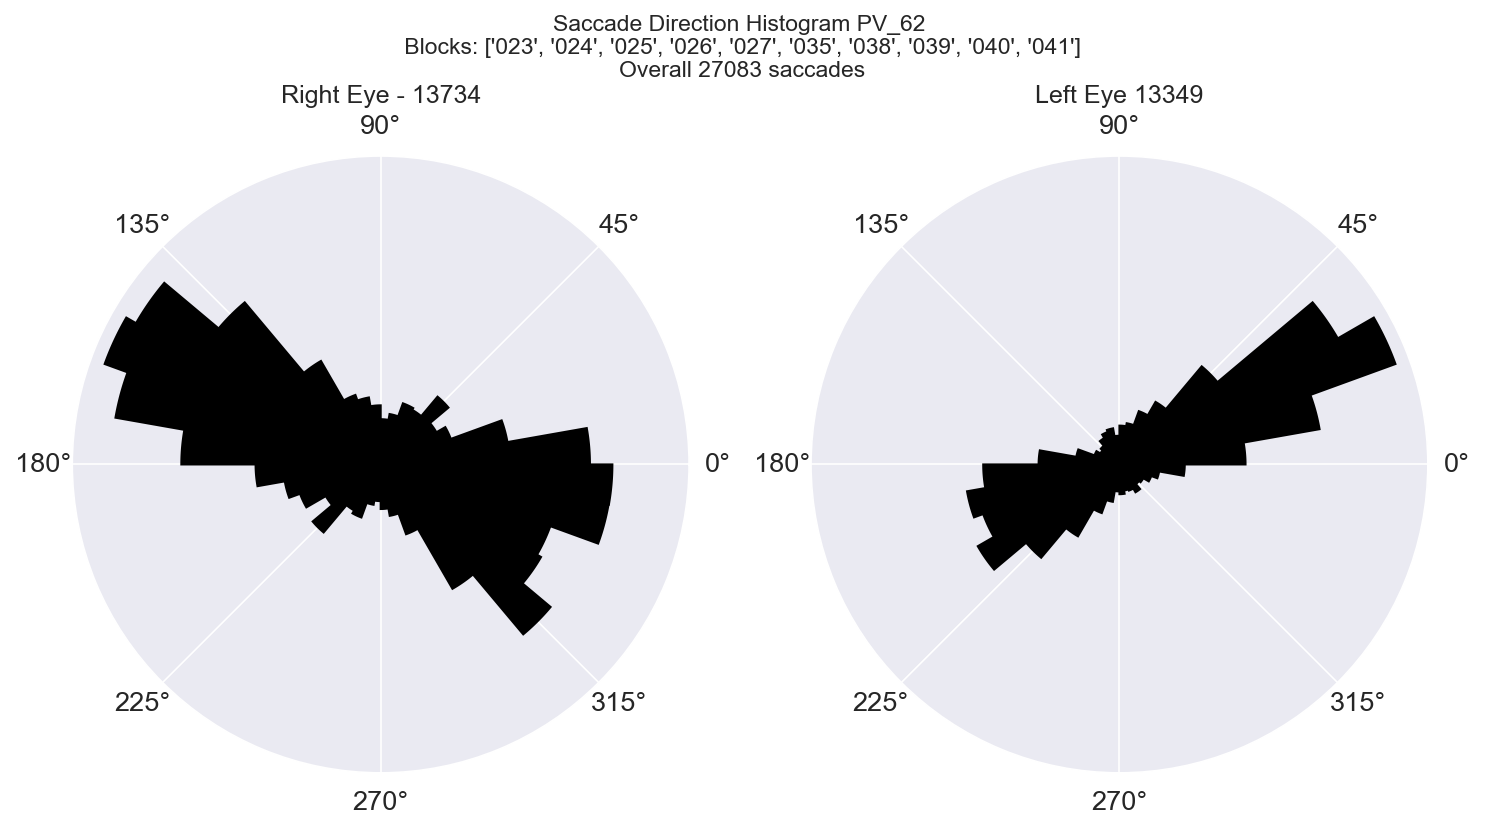

In [24]:
saccade_angles_r = saccade_collection.query('eye == "R"')['angle']
saccade_angles_l = saccade_collection.query('eye == "L"')['angle']
font_size=13
num_bins = 36
hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_collection)} saccades', fontsize=font_size-2, y=1)
fig.patch.set_facecolor('white')
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black', edgecolor='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)
    #ax.set_facecolor('white')
# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

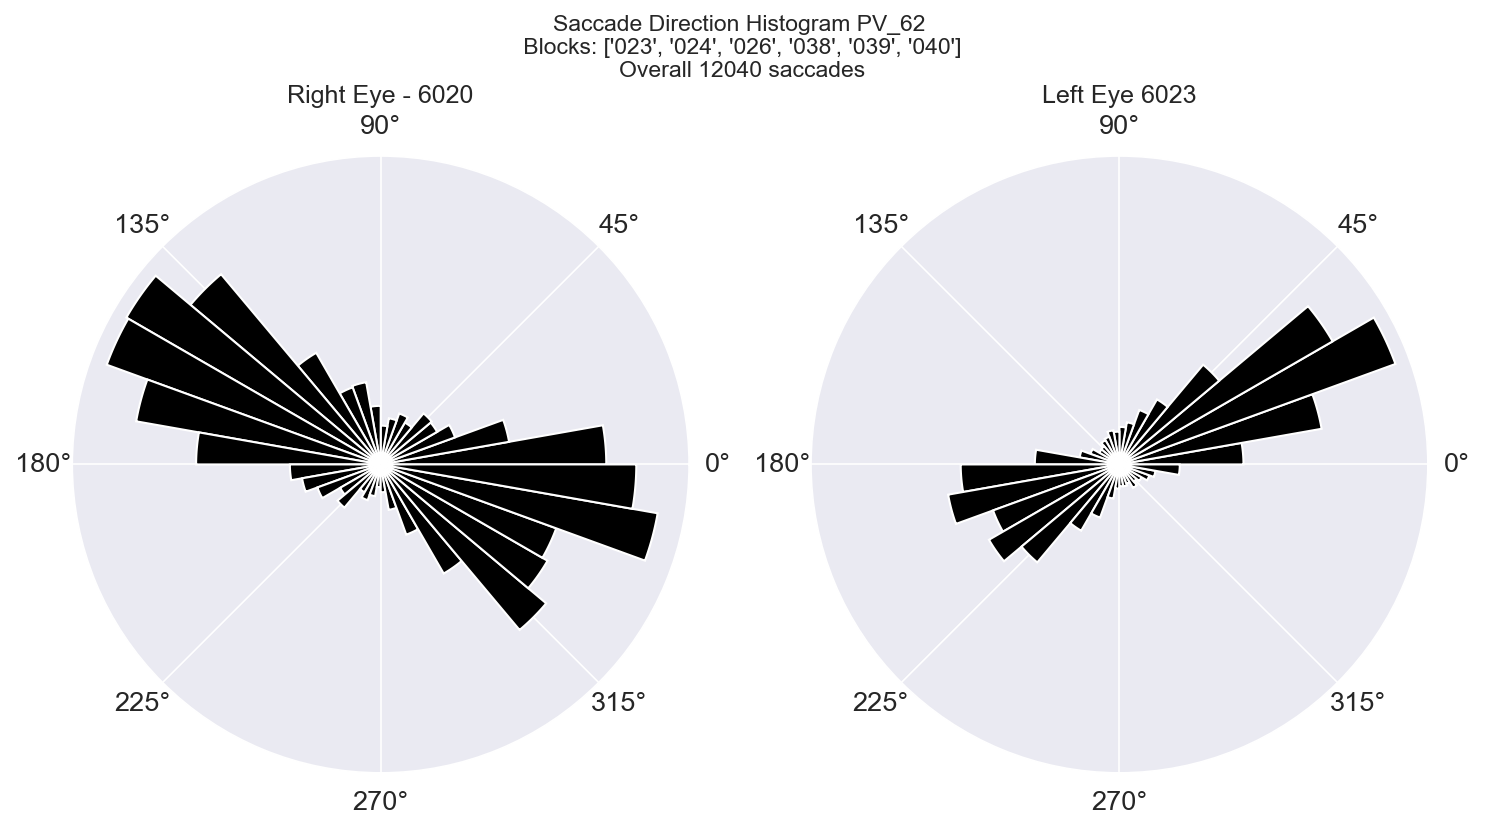

In [123]:
saccade_angles_r = saccade_collection.query('eye == "R" and synced_saccade == True')['angle']
saccade_angles_l = saccade_collection.query('eye == "L" and synced_saccade == True')['angle']
font_size=13
num_bins = 36
hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_angles_r) + len(saccade_angles_r)} saccades', fontsize=font_size-2, y=1)
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)
# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

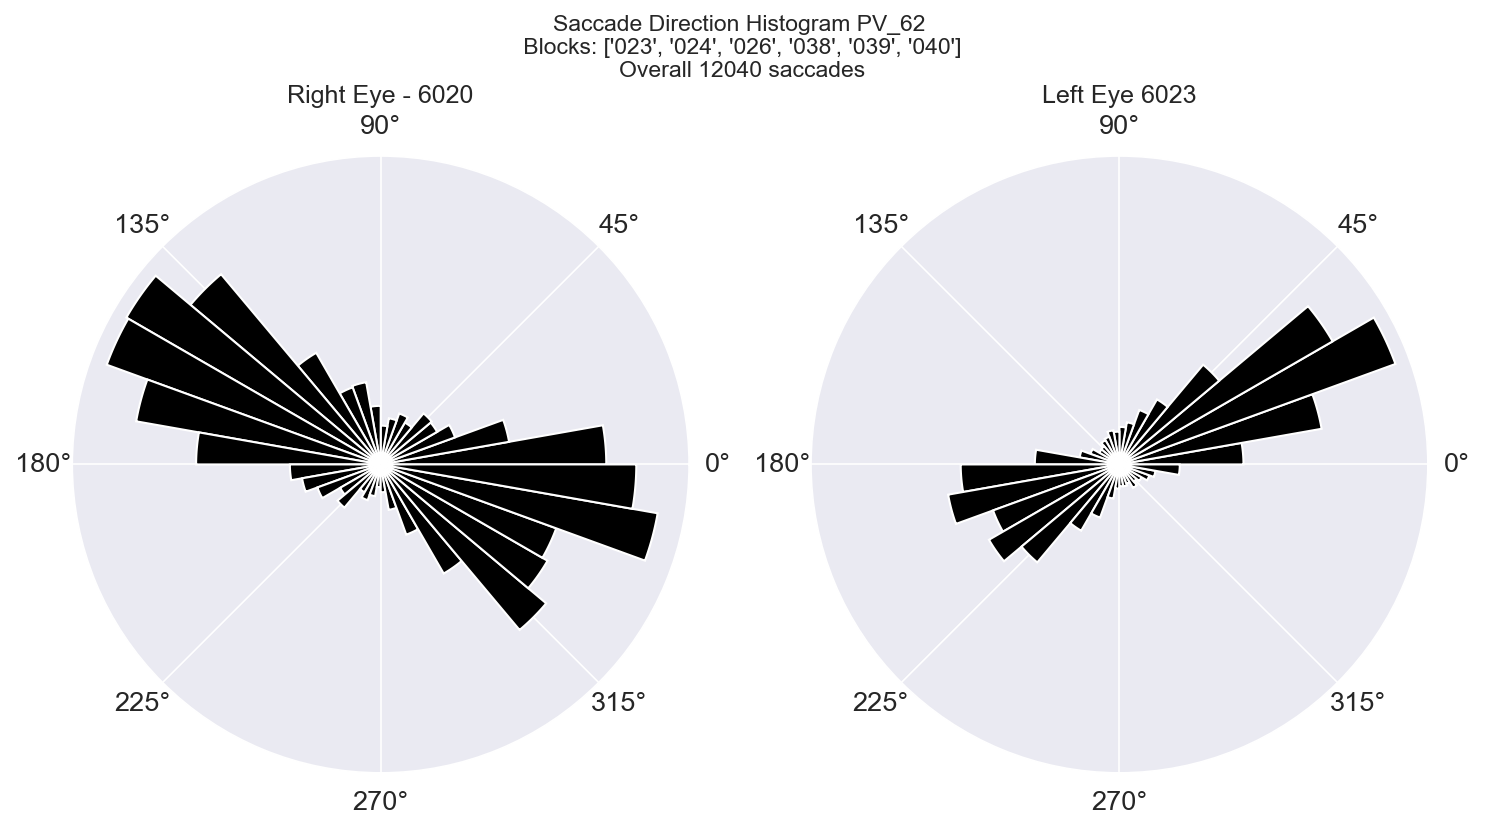

In [122]:
# Synced saccades polar scatter
saccade_angles_r = saccade_collection.query('eye == "R" and synced_saccade == True')['angle']
saccade_mags_r = saccade_collection.query('eye == "R" and synced_saccade == True')['magnitude']
saccade_angles_l = saccade_collection.query('eye == "L" and synced_saccade == True')['angle']
saccade_mags_l = saccade_collection.query('eye == "L" and synced_saccade == True')['magnitude']
font_size=13
num_bins = 36

hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360))
bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2  # Calculate bin centers

hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360))
bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2  # Calculate bin centers

fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Histogram {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(saccade_angles_r) + len(saccade_angles_r)} saccades', fontsize=font_size-2, y=1)
# Iterate over axes objects
for ax, saccade_angles, bin_centers, title in zip(axs, [saccade_angles_r, saccade_angles_l],
                                                   [bin_centers_r, bin_centers_l],
                                                   [f'Right Eye - {len(saccade_angles_r)}', f'Left Eye {len(saccade_angles_l)}']):
    hist, _ = np.histogram(saccade_angles, bins=num_bins, range=(0, 360))
    
    # Plot the polar histogram
    ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360 / num_bins), align='center', color='black')
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    ax.set_yticks([])
    ax.set_title(title,y=1)

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_angles_histogram.pdf', format='pdf')
plt.show()

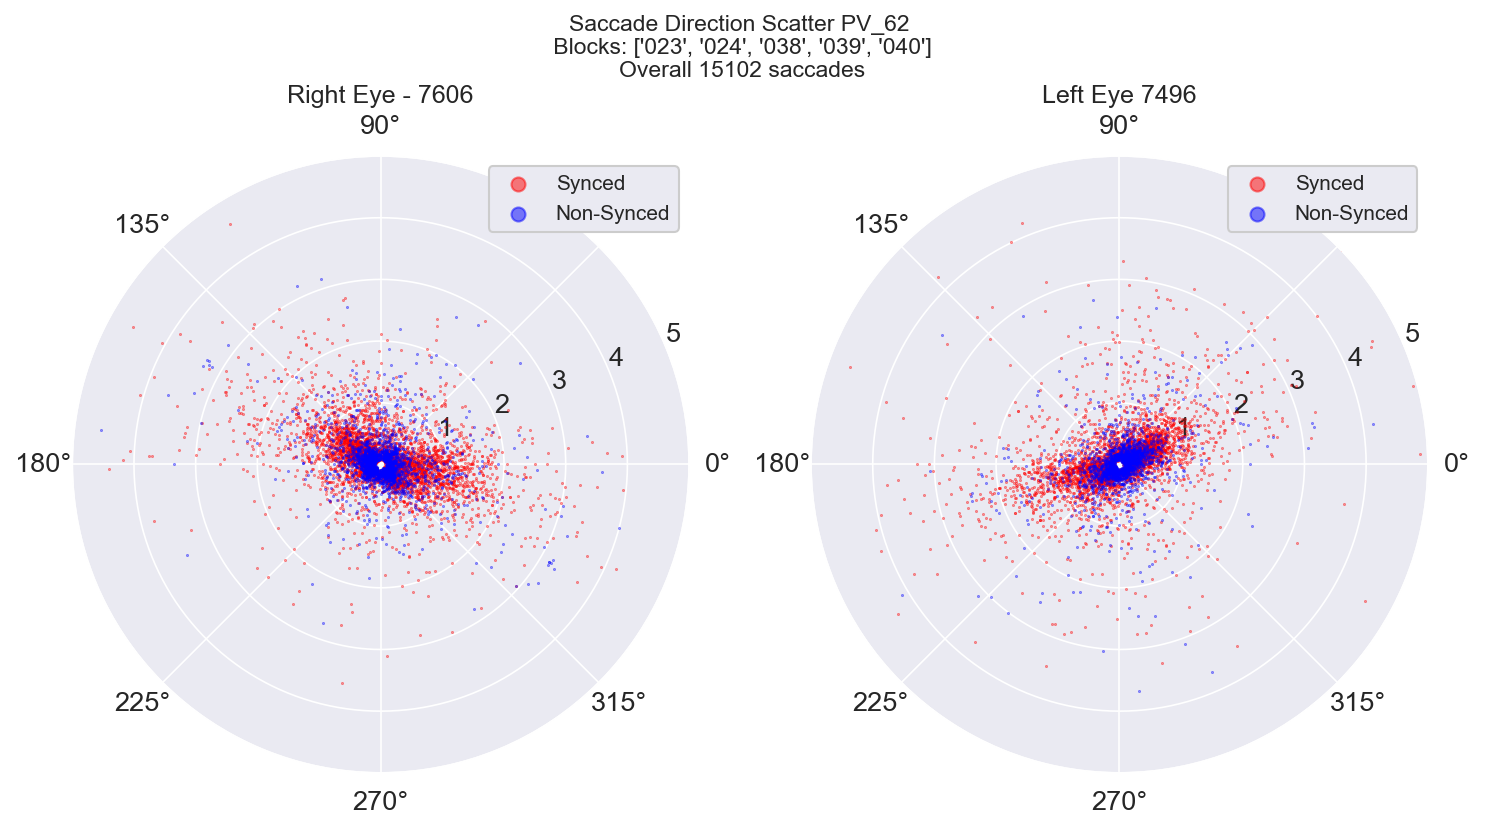

In [19]:
# Assuming you have saccade_collection and block defined somewhere in your code

font_size = 13
num_bins = 36
synced_saccades_r = saccade_collection.query('eye == "R" and synced_saccade == True').dropna()
non_synced_saccades_r = saccade_collection.query('eye == "R" and synced_saccade == False').dropna()
synced_saccades_l = saccade_collection.query('eye == "L" and synced_saccade == True').dropna()
non_synced_saccades_l = saccade_collection.query('eye == "L" and synced_saccade == False').dropna()


fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=150, subplot_kw=dict(projection='polar'))
fig.suptitle(f'Saccade Direction Scatter {block.animal_call} \n '
             f'Blocks: {[b.block_num for b in block_collection]} \n'
             f'Overall {len(synced_saccades_r) + len(non_synced_saccades_r) + len(synced_saccades_l) + len(non_synced_saccades_l)} saccades', 
             fontsize=font_size - 2, y=1)

axs[0].scatter(np.deg2rad(list(synced_saccades_r.angle.values.astype(int))), synced_saccades_r.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[0].scatter(np.deg2rad(list(non_synced_saccades_r.angle.values.astype(int))), non_synced_saccades_r.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')
axs[1].scatter(np.deg2rad(list(synced_saccades_l.angle.values.astype(int))), synced_saccades_l.magnitude.values, color='red', alpha=0.5, s=0.2, label='Synced')
axs[1].scatter(np.deg2rad(list(non_synced_saccades_l.angle.values.astype(int))), non_synced_saccades_l.magnitude.values, color='blue', alpha=0.5, s=0.2, label='Non-Synced')

for ax, title in zip(axs,[f'Right Eye - {len(synced_saccades_r) + len(non_synced_saccades_r)}',
                          f'Left Eye {len(synced_saccades_l) + len(non_synced_saccades_l)}']):
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=font_size)
    #ax.set_yticks([])
    ax.set_ylim(0,5)
    ax.set_title(title, y=1)
    ax.legend(loc='upper right',scatterpoints=1, markerscale=15, framealpha=1)
    #ax.set_ylabel('[mm]')

# Adjust layout
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_scatterplot_Synced_and_non_synced.pdf', format='pdf')
plt.show()


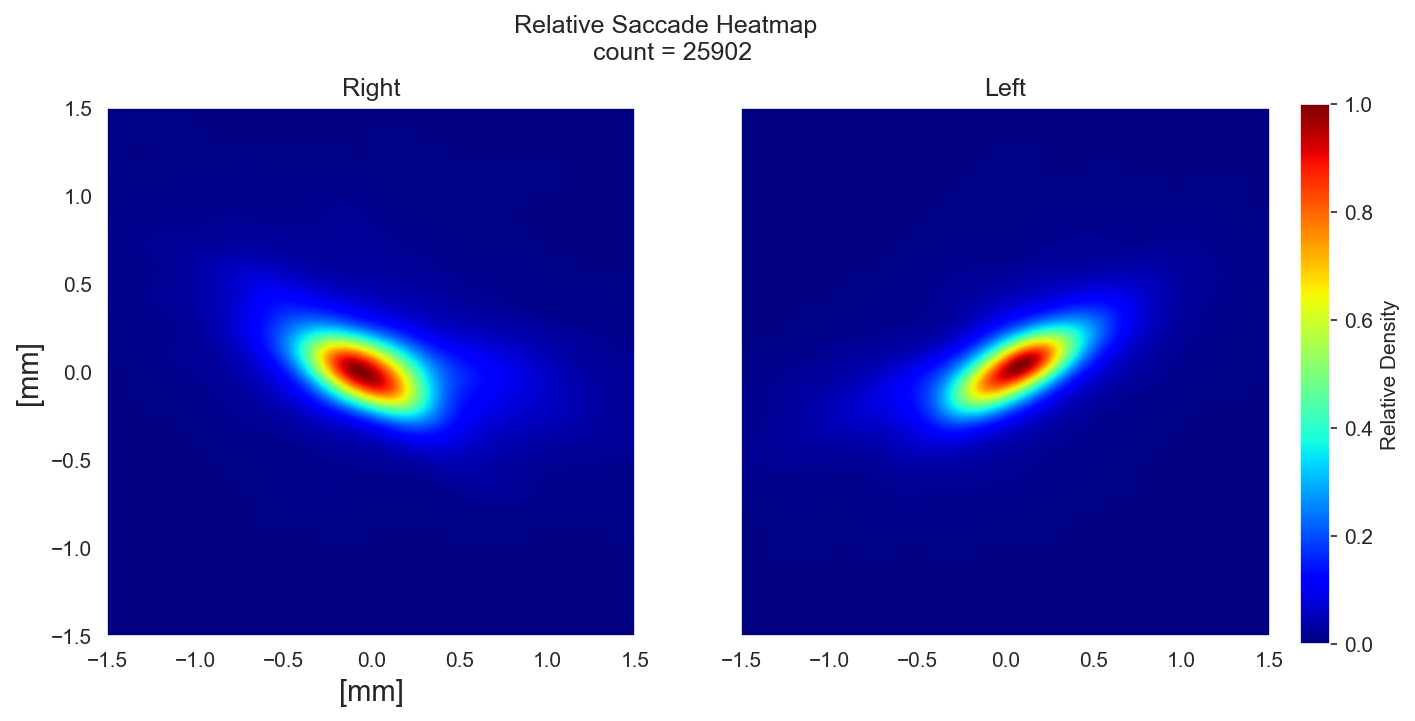

In [25]:
# Produce the all saccade heatmap
from matplotlib import colors, colorbar
saccade_df = saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_all.pdf', format='pdf')
plt.show()

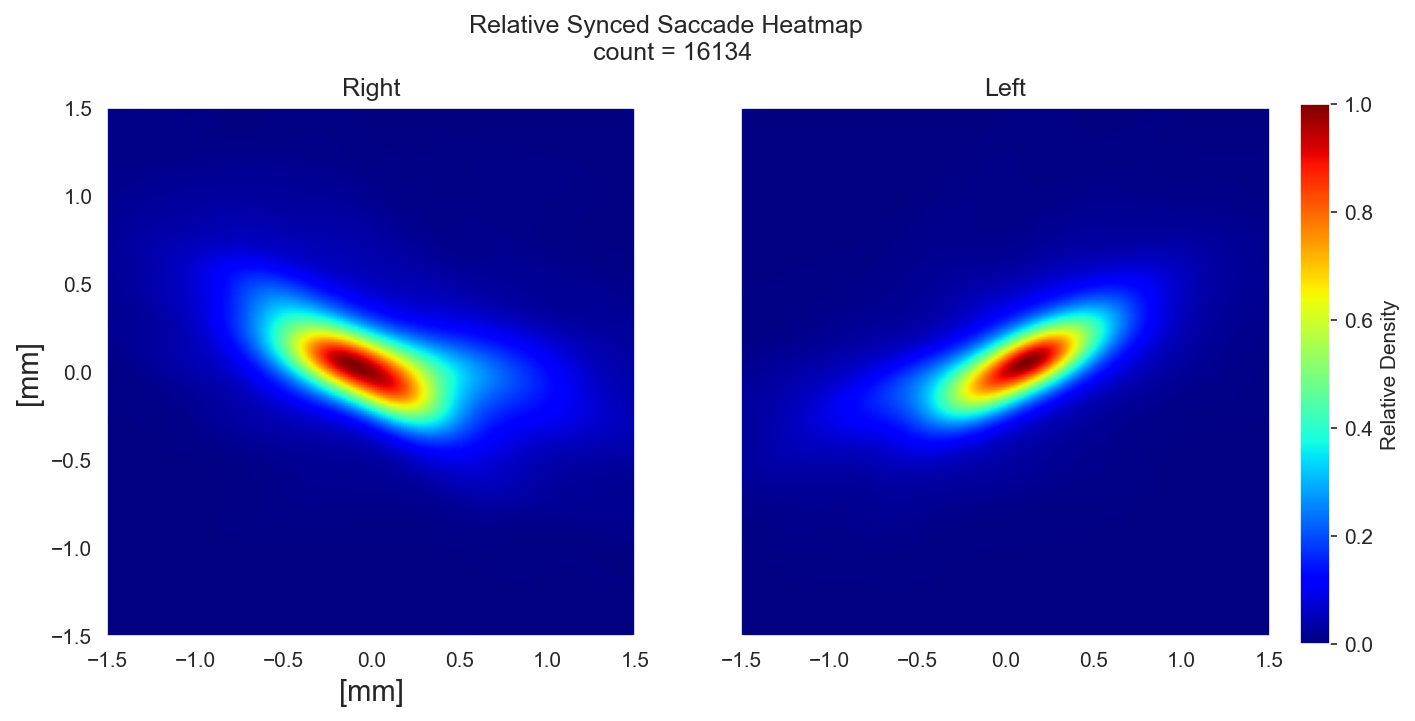

In [28]:
# Produce the synced saccade heatmap
from matplotlib import colors, colorbar
saccade_df = synced_saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L" ')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R" ')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L" ')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R" ')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Synced Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_Synced.pdf', format='pdf')
plt.show()

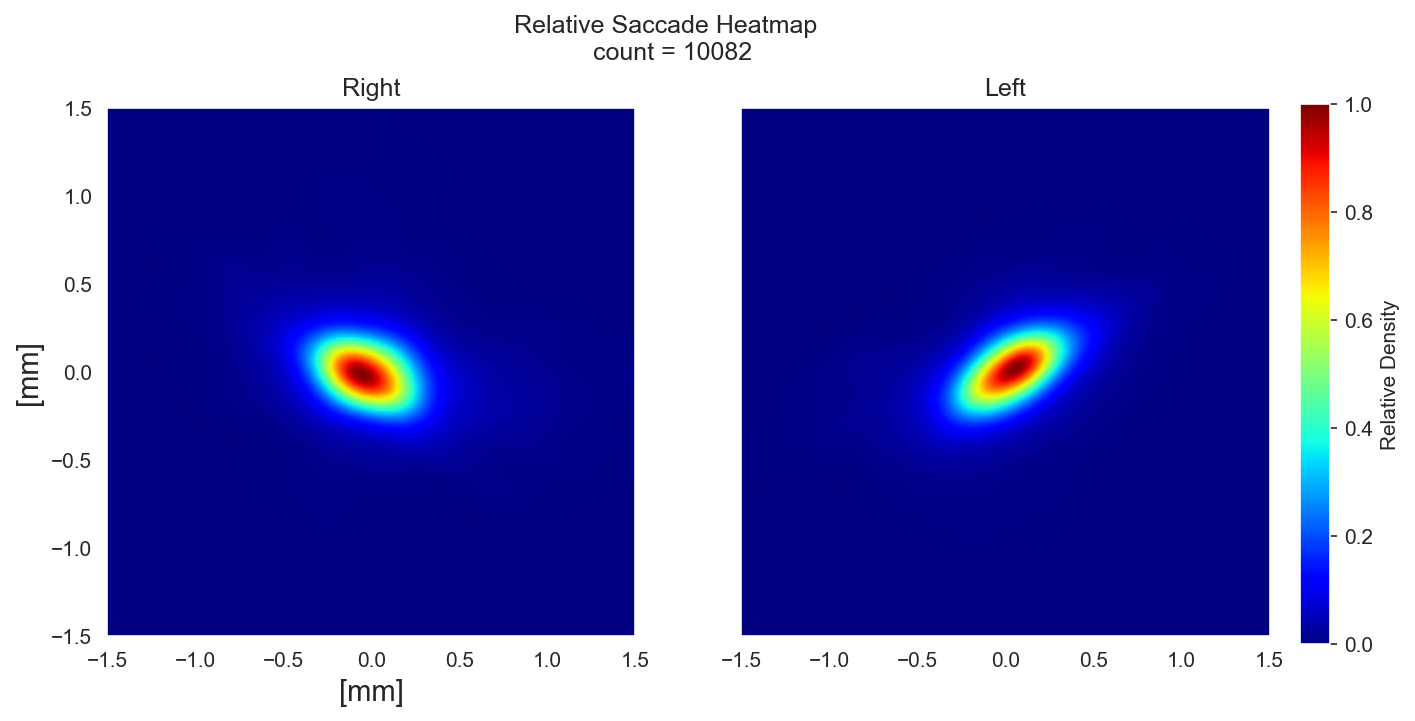

In [29]:
# Produce the non-synced saccade heatmap
from matplotlib import colors, colorbar
saccade_df = non_synced_saccade_collection.query('length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L" ')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R" ')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L" ')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R" ')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_non_synced.pdf', format='pdf')
plt.show()

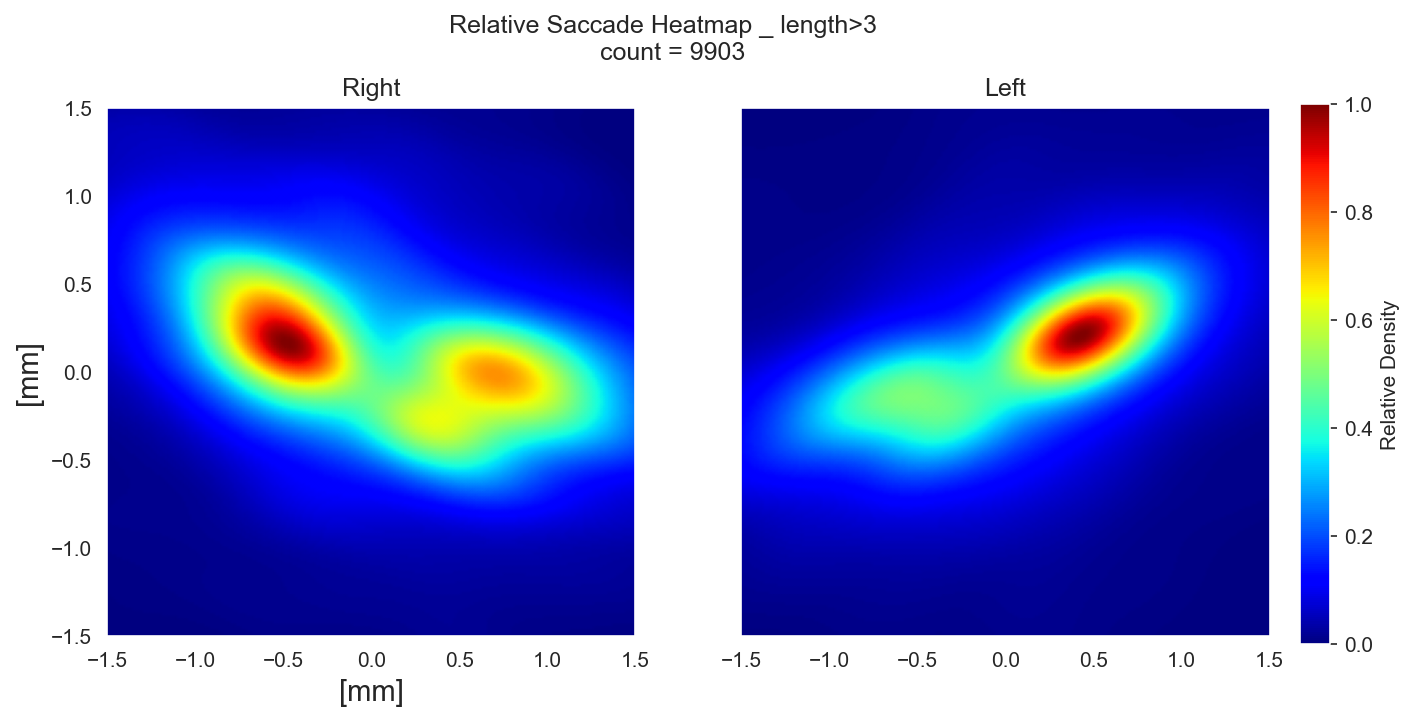

In [30]:
saccade_df = saccade_collection.query('length > 3 and length < 10').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap _ length>3  \n count = {len(l_dx) + len(r_dx)}', y=0.9)
uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')
#plt.tight_layout()

t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_long.pdf', format='pdf')
plt.show()

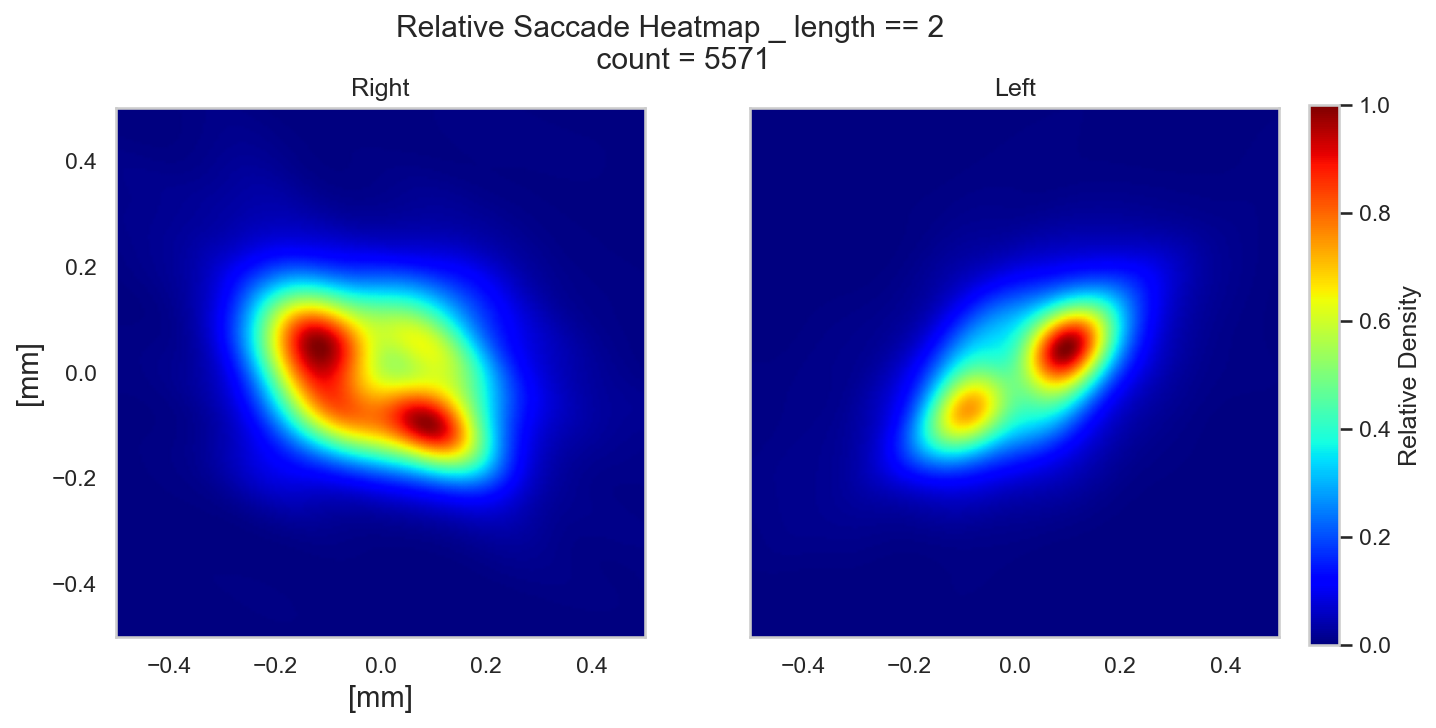

In [201]:
saccade_df = saccade_collection.query('length < 3').dropna()

# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=0.5
global_min=-0.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap _ length == 2  \n count = {len(l_dx) + len(r_dx)}', y=0.9)
uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')
#plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_short_adjusted_grid.pdf', format='pdf')
plt.show()

In [129]:
synced_saccades_times = saccade_collection.query('synced_saccade == True and eye == "L"').saccade_start_timestamp


In [36]:
l_times = saccade_collection.query('eye == "L" and synced_saccade=False').saccade_start_timestamp.values
r_times = saccade_collection.query('eye == "R"').saccade_start_timestamp.values


In [131]:
saccade_collection.query('synced_saccade == True and eye == "L"')

saccade_start_ind  saccade_start_timestamp  saccade_end_ind  \
0                     2                 788260.0                7   
2                    17                 793355.0               20   
3                    21                 794714.0               24   
4                    44                 802527.0               49   
5                    57                 806943.0               60   
...                 ...                      ...              ...   
2006             193737               66400901.0           193739   
2007             193740               66401920.0           193744   
2008             193938               66469164.0           193942   
2010             195464               66987456.0           195468   
2011             196093               67201090.0           196095   

      saccade_end_timestamp  length  magnitude       angle   initial_x  \
0                  789958.0       5   1.900819   97.615943  462.901837   
2                  794374.0       3   0.603379   36.261557  456.720948   
3                  795733.0       3   0.391622  247.436552  465.662809   
4                  804225.0       5   0.744732   88.516298  460.858502   
5                  807962.0       3   0.392117   47.674037  456.119211   
...                     ...     ...        ...         ...         ...   
2006             66401580.0       2   1.167580  172.127525  372.820853   
2007             66403278.0       4   0.371671  302.157518  335.225512   
2008             66470522.0       4   0.525409   93.389249  340.354640   
2010             66988814.0       4   0.260595  261.212854  376.676240   
2011             67201770.0       2   0.139485  303.661091  379.993954   

       initial_y       end_x       end_y  calib_dx  calib_dy eye block  \
0     271.707469  458.750908  302.751345 -0.230689  1.725272   L   023   
2     288.683031  465.415217  295.060630  0.483186  0.354437   L   023   
3     294.702316  463.134246  288.616895 -0.140526 -0.338199   L   023   
4     278.592161  461.173954  290.771144  0.017531  0.676850   L   023   
5     286.481628  460.644078  291.449867  0.251471  0.276111   L   023   
...          ...         ...         ...       ...       ...  ..   ...   
2006  247.779214  334.571506  253.068022 -1.139464  0.157556   L   040   
2007  252.041645  341.214958  242.514910  0.178428 -0.283805   L   040   
2008  243.680340  339.325637  261.055500 -0.030654  0.517613   L   040   
2010  192.743963  375.415809  184.589973 -0.037549 -0.242911   L   040   
2011  182.060881  381.784694  179.371825  0.053347 -0.080108   L   040   

      synced_saccade  min_diff  
0               True      17.0  
2               True       0.0  
3               True      14.0  
4               True      33.0  
5               True      16.0  
...              ...       ...  
2006            True      33.0  
2007            True      16.0  
2008            True      33.0  
2010            True       0.0  
2011            True       0.0  

[5231 rows x 17 columns]

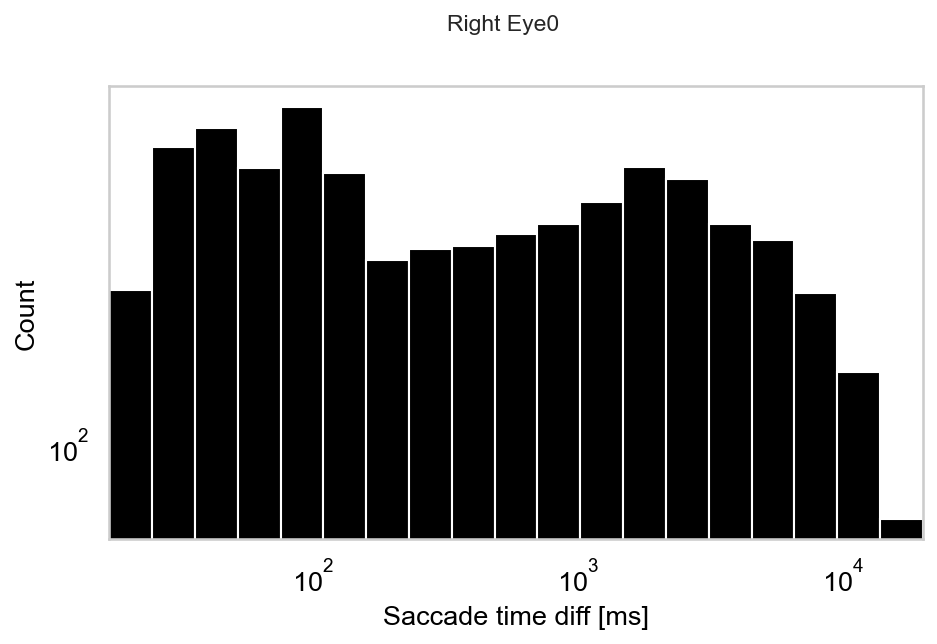

In [156]:
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
bins = np.geomspace(17, 20000, 20)
ax.hist(l_eye_saccade_diffs, bins=bins, rwidth=1, log=True, color='black', edgecolor='white')

# Set title and labels
title = 'Right Eye0'
    
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('log')
# ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xlim(left=np.min(bins))
ax.autoscale(axis='x', tight=True)
# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_right_eye_saccade_intervals.pdf', format='pdf')


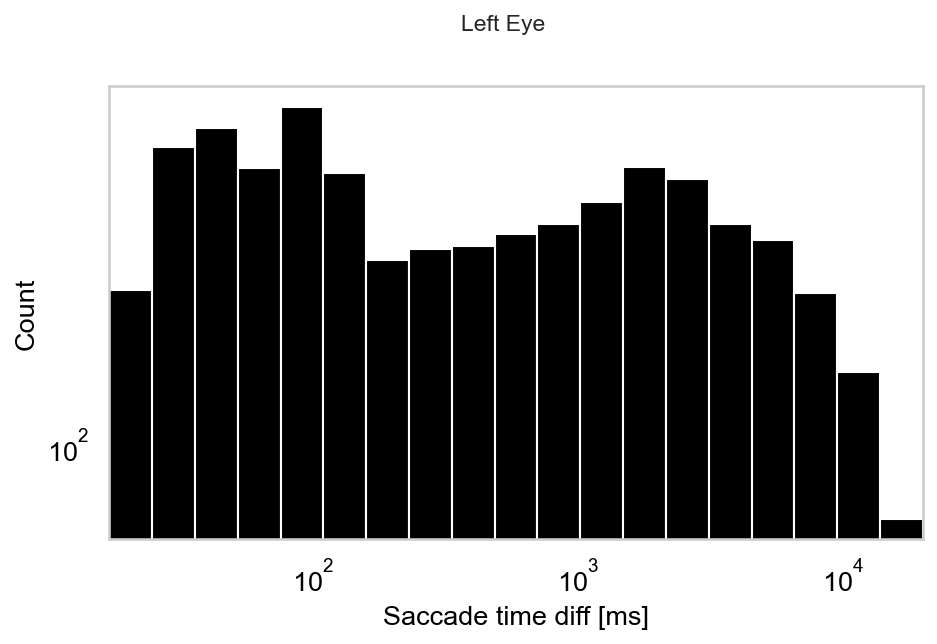

In [155]:
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
bins = np.geomspace(17, 20000, 20)
ax.hist(l_eye_saccade_diffs, bins=bins, rwidth=1, log=True, color='black', edgecolor='white')

# Set title and labels
title = 'Left Eye'
    # (f'Saccade Temporal distribution {block.animal_call} \n'
    #      f'Blocks {[b.block_num for b in block_collection]} \n '
    #      f'Overall {len(l_eye_saccade_diffs)} saccades (right_eye)')
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('log')
# ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
#ax.set_xlim(left=np.min(bins))
ax.autoscale(axis='x', tight=True)
# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_left_eye_saccade_intervals.pdf', format='pdf')


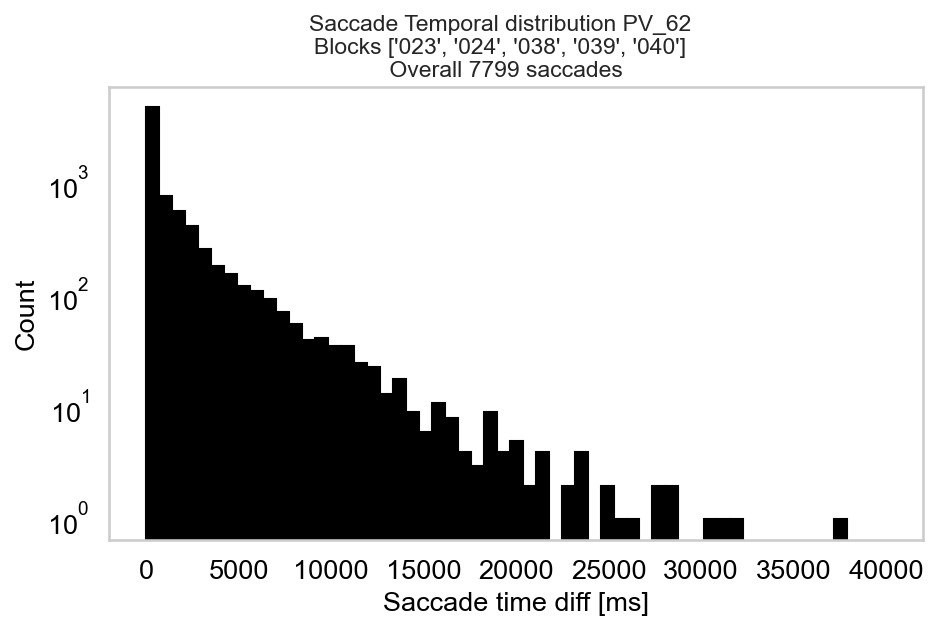

In [200]:
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
l_eye_saccade_diffs = (np.diff(l_times) // 340) * 17
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(l_eye_saccade_diffs, bins=np.linspace(0,40000,1000 // 17),log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Saccade Temporal distribution {block.animal_call} \n'
         f'Blocks {[b.block_num for b in block_collection]} \n '
         f'Overall {len(l_eye_saccade_diffs)} saccades')
fig.suptitle(title, fontsize=11, y=1)
ax.set_xlabel('Saccade time diff [ms]', fontsize=13)
ax.set_xscale('linear')
#ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
ax.grid(False)

In [145]:
# camera jitter report:
stop_indices_l = []
stop_indices_r = []
for block in block_collection:
    block.get_jitter_reports(export=False,overwrite=False,remove_led_blinks=False)
    rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
    ldf = pd.DataFrame.from_dict(block.le_jitter_dict)
    bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'])
    stop_ind_r = input('ind to stop?')
    bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'])
    stop_ind_l = input('ind to stop?')
    stop_indices_l.append(stop_ind_l)
    stop_indices_r.append(stop_ind_r)
    

jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
Jitter report computed - check out re/le_jitter_dict attributes


In [146]:
stop_arr_l = np.array(stop_indices_l).astype(int)
stop_arr_r = np.array(stop_indices_r).astype(int)

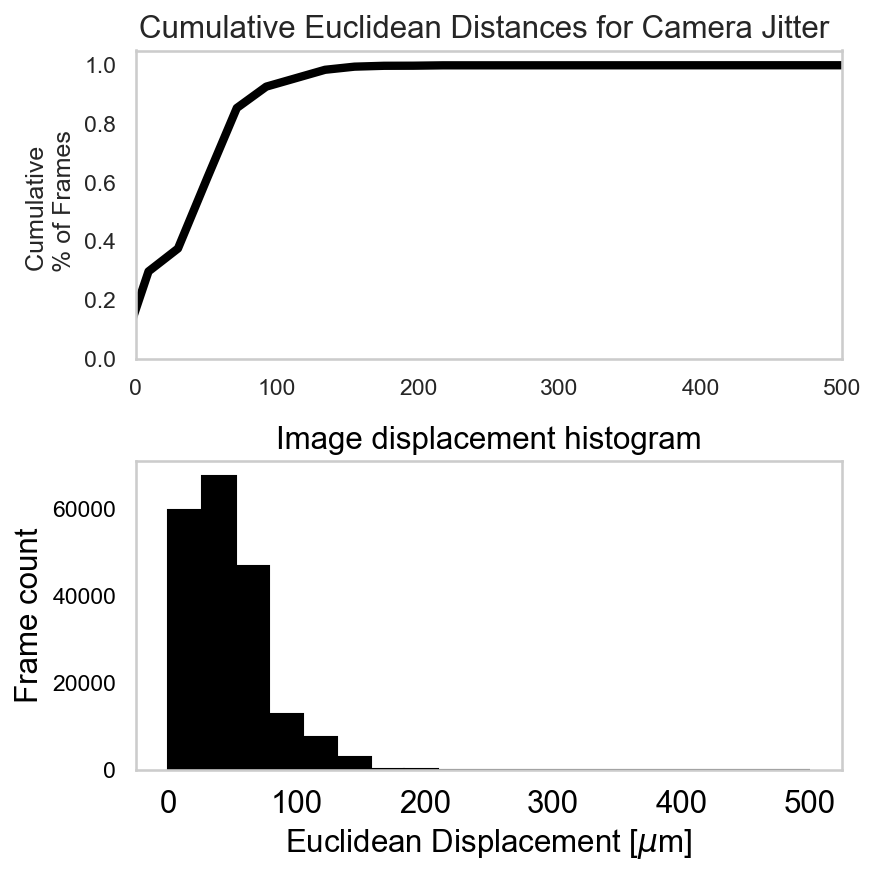

In [147]:
distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

# Create cumulative distribution plot
sns.set(style="whitegrid")
fig, axs = plt.subplots(2,figsize=(6,6),dpi=150)
#plt.suptitle(f'Cumulative Euclidean Distances for Camera Jitter')
axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter ', fontsize=15)
axs[0].set_ylabel('Cumulative \n % of Frames')
axs[0].set_xlim(0,500)
axs[0].grid(False)
#axs[0].tick_params(axis='both', which='major', labelsize=15)


# Create histogram and cumulative distribution
sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
# Calculate the ECDF
# sorted_distances = np.sort(distances)
# cumulative_percentage = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
# # Find x-value corresponding to 0.95 cumulative from ECDF
# target_cumulative = 0.95
# x_value_at_target_cumulative = np.interp(target_cumulative, cumulative_percentage, sorted_distances)
# 
# 
# # Highlight the point with a circle and add guidelines
# axs[0].scatter(x_value_at_target_cumulative, target_cumulative, color='red', marker='o', label=f'0.95 Cumulative Point')
# axs[0].axvline(x=x_value_at_target_cumulative, color='red', linestyle='--', linewidth=2)
# axs[0].axhline(y=target_cumulative, color='red', linestyle='--', linewidth=2)
# Plot the histogram
axs[1].hist(distances,bins=np.linspace(0,500,20),log=False, color='black', edgecolor='black')

# Set title and labels
title = f'Image displacement histogram'
axs[1].set_title(title, fontsize=15)
axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
axs[1].set_xscale('linear')
axs[1].set_yscale('linear')
axs[1].set_ylabel('Frame count', fontsize=15)

# Adjust tick label sizes
axs[1].tick_params(axis='x', which='major', labelsize=15)

# Set white background and black text
#fig.patch.set_facecolor('white')
axs[1].set_facecolor('white')
axs[1].title.set_color('black')
axs[1].xaxis.label.set_color('black')
axs[1].yaxis.label.set_color('black')
axs[1].tick_params(colors='black')
axs[1].grid(False)


# Display legend
#plt.legend()
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Jitter_Histogram_only_stable_stuff.pdf', format='pdf')
plt.show()

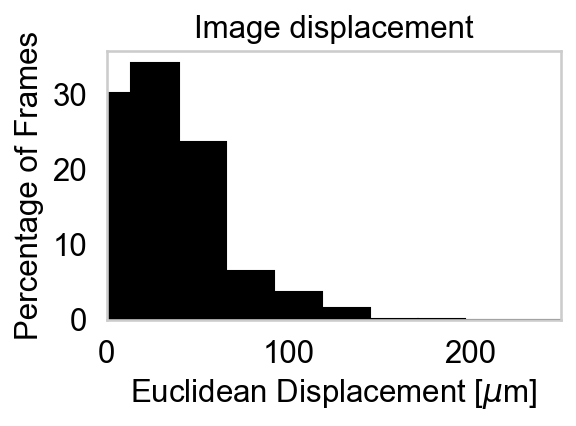

In [151]:

distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

# Create cumulative distribution plot
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, figsize=(4, 3), dpi=150)

# Plot the histogram
hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 20))
percentage = (hist / len(distances)) * 100
axs.bar(bins[:-1], percentage, width=np.diff(bins), color='black', edgecolor='black')

# Set title and labels for the histogram
title = f'Image displacement'# histogram \n {len(distances)} frames ({len(distances) // 60 // 60} minutes)'
axs.set_title(title, fontsize=15)
axs.set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
axs.set_ylabel('Percentage of Frames', fontsize=15)

# Adjust tick label sizes
axs.tick_params(axis='both', which='major', labelsize=15)

# Set white background and black text
axs.set_facecolor('white')
axs.title.set_color('black')
axs.xaxis.label.set_color('black')
axs.yaxis.label.set_color('black')
axs.tick_params(colors='black')
axs.grid(False)
axs.set_xlim(0,250)

plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Jitter_Histogram_only_stable_stuff_relative.pdf', format='pdf')